# Teste Avaliação de Risco de Credito (Porto Seguro)

## Entendimento do problema de Negócio

Construir um **modelo que preveja a probabilidade de um motorista fazer um sinistro de seguro auto no próximo ano**

**"Sinistro"** é um termo usado no setor de seguros para se referir a um evento em que o segurado sofre um prejuízo coberto pela sua apólice e, consequentemente, faz uma reclamação ou solicitação de indenização à seguradora. No contexto de seguro auto, um sinistro pode envolver situações como:

1. Acidentes de trânsito (colisões, capotagens, etc.);
2. Roubo ou furto do veículo;
3. Danos causados por fenômenos naturais (enchentes, granizo, etc.);
4. Danos causados por terceiros (vandalismo, por exemplo);
5. Entre outros.

Após a ocorrência de um sinistro, o segurado deve entrar em contato com a seguradora para informar o ocorrido e iniciar o processo de avaliação e eventual indenização, conforme estabelecido na apólice de seguro.   

## Entendimento dos Dados

Para este projeto utilizaremos os dados disponibilizados pela seguradora Porto Seguro no ambiente Kaggle:

https://www.kaggle.com/competitions/porto-seguro-safe-driver-prediction/data

Nos dados de treino e teste:
- variáveis que pertencem a agrupamentos similares são marcadas como tal nos nomes das variáveis (por exemplo, ind, reg, car, calc).

- Os nomes das variáveis incluem o sufixo "bin" para indicar variáveis binárias e "cat" para indicar varipaveis categóricas. Variáveis sem essas designações são contínuas ou ordinais.

- Valores de -1 indicam nulo.

- A coluna "target" indica se uma reclamação (sinistro) foi feita ou não para aquele titular da apólice.

O arquivo train.csv contém os dados de treino, onde cada linha corresponde a um titular de apólice, e a coluna "target" indica que uma reclamação foi feita.
O arquivo test.csv contém os dados de teste.


## Data Prep


## Data Preparation

Nesta etapa, realizamos o tratamento dos dados para garantir qualidade, consistência e adequação às técnicas de Machine Learning.

Inicialmente, os valores ausentes codificados como -1 foram convertidos para NaN. Em seguida, foi analisada a proporção de valores ausentes por feature, permitindo a remoção de variáveis com alta taxa de ausência.

Para as features com baixa proporção de valores nulos, foi aplicada imputação pela média, calculada exclusivamente a partir da base de treino, evitando vazamento de dados e garantindo consistência entre treino e validação.

Durante esse processo, variáveis sensíveis, como identificadores e a variável alvo, foram temporariamente removidas das transformações.


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#arquivo .py
import sys
sys.path.append('/Volumes/workspace/data_science/medium/')
import functions as fun

In [0]:
#Importando os dados

df_0 = pd.read_csv('/Volumes/workspace/data_science/medium/porto_seguro/files/train (1).csv')
df_0.head()

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [0]:
df_0.shape

(595212, 59)

- 59 features
- 595212 linhas

In [0]:
df_0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 595212 entries, 0 to 595211
Data columns (total 59 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              595212 non-null  int64  
 1   target          595212 non-null  int64  
 2   ps_ind_01       595212 non-null  int64  
 3   ps_ind_02_cat   595212 non-null  int64  
 4   ps_ind_03       595212 non-null  int64  
 5   ps_ind_04_cat   595212 non-null  int64  
 6   ps_ind_05_cat   595212 non-null  int64  
 7   ps_ind_06_bin   595212 non-null  int64  
 8   ps_ind_07_bin   595212 non-null  int64  
 9   ps_ind_08_bin   595212 non-null  int64  
 10  ps_ind_09_bin   595212 non-null  int64  
 11  ps_ind_10_bin   595212 non-null  int64  
 12  ps_ind_11_bin   595212 non-null  int64  
 13  ps_ind_12_bin   595212 non-null  int64  
 14  ps_ind_13_bin   595212 non-null  int64  
 15  ps_ind_14       595212 non-null  int64  
 16  ps_ind_15       595212 non-null  int64  
 17  ps_ind_16_

Para predição,iremos pegar os dados de 1 ano atrás para poder prever como o evento irá acontecer em 1 ano, a quantidade de dias para trás que queremos pegar será de acordo com a quantidade de dias para frente que queremos prever.

*EX: Se eu quero prever 6 meses, eu buscaria dados de 6 meses no passado da data presente da analise.*

Mas cuidado quanto mais distante a predição tiver da referencia menos poder preditivo iremos ter, ou seja, fazer uma predição muito longa pode afetar na predição do modelo.

In [0]:

def missing_values_table(df):

  metadados = pd.DataFrame({
      'nome_variavel': df.columns,
      'tipos_de_dados': df.dtypes,
      'numero_de_missing': df.isnull().sum(),
      'percentual_de_missing': df.isnull().sum() * 100 / len(df),
      'unknown': df.isin(['unknown']).sum(),
      'percentual_unknown': df.isin(['unknown']).sum() * 100 / len(df),
      'numero_de_unicos': df.nunique(),
  })
  metadados = metadados.sort_values(by='numero_de_missing', ascending=False).round(1)
  metadados = metadados.reset_index(drop=True)

  return metadados

metadados = missing_values_table(df_0)
metadados.head(21)

,nome_variavel,tipos_de_dados,numero_de_missing,percentual_de_missing,unknown,percentual_unknown,numero_de_unicos
0,id,int64,0,0.0,0,0.0,595212
1,ps_calc_06,int64,0,0.0,0,0.0,11
2,ps_car_10_cat,int64,0,0.0,0,0.0,3
3,ps_car_11_cat,int64,0,0.0,0,0.0,104
4,ps_car_11,int64,0,0.0,0,0.0,5
5,ps_car_12,float64,0,0.0,0,0.0,184
6,ps_car_13,float64,0,0.0,0,0.0,70482
7,ps_car_14,float64,0,0.0,0,0.0,850
8,ps_car_15,float64,0,0.0,0,0.0,15
9,ps_calc_01,float64,0,0.0,0,0.0,10


Podemos verificar que nessa primeira verificação, não temos NaN, entretando ao lermos as informações dos dado, verificamos que o dados nulos estão sinalizados como '-1', então se faz necessário verificar quais features possuem '-1' para fazermos a mudança para Nan

Mas antes de qualquer processo, os dados brutos serão dividido em treino e teste para que futuramente possamos fazer a validação desse projeto antes mesmo de ser feito a aplicação com os dados de teste já enviados no projeto.
Isso ocorre que nessa situação, teremos que fazer o modelo de validação nesse banco de dados teste criado para ai sim, após toda a nossa analise e verificação do melhor modelo, a gente aplicar no modelo de teste enviado pela competição.

In [0]:
#Separando dados em treino e teste
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_0,test_size = 0.3, random_state = 42)
train.shape, test.shape

((416648, 59), (178564, 59))

In [0]:
df_train_01 = train.copy()
df_test_01 = test.copy()

In [0]:
#Substituindo valor -1 por nan

df_train_01.replace(-1, np.nan,inplace=True)

metadados = missing_values_table(df_train_01)
metadados.head(21)

,nome_variavel,tipos_de_dados,numero_de_missing,percentual_de_missing,unknown,percentual_unknown,numero_de_unicos
0,ps_car_03_cat,float64,287957,69.1,0,0.0,2
1,ps_car_05_cat,float64,186779,44.8,0,0.0,2
2,ps_reg_03,float64,75228,18.1,0,0.0,4965
3,ps_car_14,float64,29746,7.1,0,0.0,831
4,ps_car_07_cat,float64,8018,1.9,0,0.0,2
5,ps_ind_05_cat,float64,4057,1.0,0,0.0,7
6,ps_car_09_cat,float64,393,0.1,0,0.0,5
7,ps_ind_02_cat,float64,139,0.0,0,0.0,4
8,ps_car_01_cat,float64,69,0.0,0,0.0,12
9,ps_ind_04_cat,float64,55,0.0,0,0.0,2


Agora podemos verificar que existe um alta porcentagem de valores nulos em algumas features. Como isso se faz necessário fazer um filtro para a exclusão de features que possuem alta porcentagem de nulos para evitar que esses comprometam os modelos.

### Excluindo features

In [0]:
missing_cutoff = 68

drop_vars_nulos = metadados[(metadados['percentual_de_missing'] >= missing_cutoff)]
lista_drop_vars = list(drop_vars_nulos.nome_variavel.values)

print('Variáveis que serão excluídas por alto percentual de nulos: ',lista_drop_vars)

# retirando lista de variáveis com alto percentual de nulos
df_train_02 = df_train_01.drop(axis=1,columns=lista_drop_vars)
df_train_02.shape

Variáveis que serão excluídas por alto percentual de nulos:  ['ps_car_03_cat']


(416648, 58)

In [0]:
# Salvando arquivo
import pickle

with open('/Volumes/workspace/data_science/medium/porto_seguro/artifacts/prd_drop_nullvars.pkl', 'wb') as f:
    pickle.dump(lista_drop_vars, f)

In [0]:
with open('/Volumes/workspace/data_science/medium/porto_seguro/artifacts/prd_drop_nullvars.pkl', 'rb') as f:
  loaded_drop = pickle.load(f)
loaded_drop
#Aplicando no test
test_prod = test.copy()
test_prod = test_prod.drop(axis=1,columns=loaded_drop)
test_prod.shape

(178564, 58)

In [0]:
df_train_02 = df_train_02.drop(axis=1, columns=['id', 'target'])
df_train_02.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
391389,7,1.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,10,1,0,0,0.9,1.6,1.692262,11.0,0.0,1,1.0,17,NaN,1,2.0,1,104,2.0,0.447214,1.550513,0.415812,3.316625,0.7,0.9,0.2,1,3,9,3,10,2,7,5,2,4,10,0,1,1,0,0,1
518243,5,1.0,3,1.0,0.0,0,1,0,0,0,0,0,0,0,9,1,0,0,0.5,0.5,0.803508,6.0,1.0,0,1.0,1,1.0,1,0.0,1,85,3.0,0.374166,0.698345,0.397492,2.645751,0.9,0.7,0.8,3,3,7,5,9,3,5,3,1,6,12,0,1,1,0,1,0
136933,0,1.0,6,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.9,1.4,1.229583,6.0,1.0,0,1.0,5,1.0,1,0.0,1,104,3.0,0.399750,0.568782,0.393065,1.732051,0.8,0.2,0.8,1,2,8,5,9,2,14,4,3,4,10,0,0,1,0,1,0
432345,0,1.0,4,1.0,0.0,1,0,0,0,0,0,0,0,0,6,0,0,1,0.1,0.1,NaN,7.0,1.0,0,NaN,1,1.0,1,2.0,1,40,2.0,0.374166,0.770210,0.381445,3.464102,0.1,0.0,0.8,4,2,7,1,10,2,9,5,3,4,8,0,0,1,0,1,0
127021,1,1.0,2,0.0,0.0,0,0,0,1,0,0,0,0,0,6,0,1,0,0.9,0.5,0.761577,7.0,1.0,0,0.0,4,0.0,1,2.0,1,12,3.0,0.400000,0.830115,0.324808,3.464102,0.8,0.4,0.9,2,3,8,3,8,4,4,8,1,4,5,0,1,1,1,1,0


In [0]:
def custom_fillna(df):
    import pandas as pd
    import numpy as np

    # Substituindo -1 por nulos
    # Esta função serve para este modelo ou caso específico, porque pode ser que em outras situações o missing não venha marcado com -1

    df.replace(-1, np.nan, inplace=True)
    numerical_cols = df.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns
    means = {}

    for col in numerical_cols:
        means[col] = df[col].mean()
        df[col].fillna(means[col], inplace=True)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('POD_VERIFICAR')

    return df, means


In [0]:
df_train_03, means = custom_fillna(df_train_02)

In [0]:
# Salvando as médias encontradas em cada feature no banco de dados de treino

with open('/Volumes/workspace/data_science/medium/porto_seguro/artifacts/prd_fillna.pkl', 'wb') as f:
  pickle.dump(means, f)

In [0]:
with open('/Volumes/workspace/data_science/medium/porto_seguro/artifacts/prd_fillna.pkl', 'rb') as f:
  loaded_means = pickle.load(f)
loaded_means

{'ps_ind_01': 1.902154816535781,
 'ps_ind_02_cat': 1.359569661159783,
 'ps_ind_03': 4.4241902037211265,
 'ps_ind_04_cat': 0.4168841051097834,
 'ps_ind_05_cat': 0.41899605178009214,
 'ps_ind_06_bin': 0.39382644342466544,
 'ps_ind_07_bin': 0.2568019047253317,
 'ps_ind_08_bin': 0.16375453620322192,
 'ps_ind_09_bin': 0.185617115646781,
 'ps_ind_10_bin': 0.0003672164512970181,
 'ps_ind_11_bin': 0.0016608744071734413,
 'ps_ind_12_bin': 0.009283615905992589,
 'ps_ind_13_bin': 0.0009048405368560511,
 'ps_ind_14': 0.0122165473013191,
 'ps_ind_15': 7.298587776732398,
 'ps_ind_16_bin': 0.6603967857760028,
 'ps_ind_17_bin': 0.1215630460244619,
 'ps_ind_18_bin': 0.15339567212611124,
 'ps_reg_01': 0.6111741806032911,
 'ps_reg_02': 0.43951201013805413,
 'ps_reg_03': 0.8943857761820005,
 'ps_car_01_cat': 8.297888275693206,
 'ps_car_02_cat': 0.8304171886925592,
 'ps_car_04_cat': 0.7271941782991878,
 'ps_car_05_cat': 0.5257559740547877,
 'ps_car_06_cat': 6.554612046619688,
 'ps_car_07_cat': 0.9478403445

In [0]:
# Aplicando as médias encontradas no banco de dados do test

def custom_fillna_prod(df, means):
    import numpy as np
    import pandas as pd
    df.replace(-1, np.nan, inplace=True)
    for col, mean_value in means.items():
      df[col] = df[col].fillna(mean_value)

    categorical_cols = df.select_dtypes(include=['object']).columns
    df[categorical_cols] = df[categorical_cols].fillna('POD_VERIFICAR')
    return df

In [0]:
#Aplicando no banco de dados de teste
test_prod = test_prod.drop(axis=1, columns=['id', 'target'])
custom_fillna_prod(test_prod, loaded_means)
test_prod.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
256886,4,1.0,5,1.0,0.0,1,0,0,0,0,0,0,0,0,8,0,1,0,0.7,1.4,1.368393,10.0,1.0,0,1.000000,11,1.0,1,0.0,1,16,3.0,0.421782,0.596720,0.373497,1.414214,0.0,0.3,0.2,5,0,8,3,9,3,7,7,3,2,3,0,1,0,1,0,0
118785,6,2.0,10,1.0,0.0,0,0,0,1,0,0,0,0,0,5,1,0,0,0.9,1.4,1.798437,10.0,0.0,0,1.000000,5,1.0,1,0.0,1,104,1.0,0.424264,1.237825,0.446094,3.162278,0.3,0.8,0.3,1,1,8,4,8,4,9,6,3,3,5,0,1,1,0,0,0
56083,4,1.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,10,0,0,0,0.1,0.1,0.894386,11.0,1.0,0,1.000000,1,1.0,1,1.0,1,31,3.0,0.400000,0.546628,0.374724,1.000000,0.2,0.6,0.3,5,1,8,2,8,2,12,3,1,0,7,0,0,1,0,0,0
542002,0,1.0,7,1.0,4.0,0,1,0,0,0,0,0,0,0,3,0,0,1,0.9,1.3,0.868907,11.0,1.0,0,1.000000,15,1.0,0,2.0,1,97,3.0,0.360555,0.874147,0.298329,3.605551,0.4,0.8,0.1,3,2,7,4,10,2,5,1,1,3,6,1,1,0,0,0,0
349518,1,1.0,3,1.0,0.0,1,0,0,0,0,0,0,0,0,12,0,1,0,0.6,0.4,0.741620,11.0,1.0,0,0.525756,1,1.0,1,2.0,1,38,3.0,0.316228,0.740165,0.359861,3.464102,0.0,0.8,0.9,3,2,10,3,11,3,10,6,1,5,6,0,1,0,0,0,0


In [0]:
df_train_03.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
391389,7,1.0,9,1.0,0.0,0,0,1,0,0,0,0,0,0,10,1,0,0,0.9,1.6,1.692262,11.0,0.0,1,1.000000,17,0.94784,1,2.0,1,104,2.0,0.447214,1.550513,0.415812,3.316625,0.7,0.9,0.2,1,3,9,3,10,2,7,5,2,4,10,0,1,1,0,0,1
518243,5,1.0,3,1.0,0.0,0,1,0,0,0,0,0,0,0,9,1,0,0,0.5,0.5,0.803508,6.0,1.0,0,1.000000,1,1.00000,1,0.0,1,85,3.0,0.374166,0.698345,0.397492,2.645751,0.9,0.7,0.8,3,3,7,5,9,3,5,3,1,6,12,0,1,1,0,1,0
136933,0,1.0,6,1.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0.9,1.4,1.229583,6.0,1.0,0,1.000000,5,1.00000,1,0.0,1,104,3.0,0.399750,0.568782,0.393065,1.732051,0.8,0.2,0.8,1,2,8,5,9,2,14,4,3,4,10,0,0,1,0,1,0
432345,0,1.0,4,1.0,0.0,1,0,0,0,0,0,0,0,0,6,0,0,1,0.1,0.1,0.894386,7.0,1.0,0,0.525756,1,1.00000,1,2.0,1,40,2.0,0.374166,0.770210,0.381445,3.464102,0.1,0.0,0.8,4,2,7,1,10,2,9,5,3,4,8,0,0,1,0,1,0
127021,1,1.0,2,0.0,0.0,0,0,0,1,0,0,0,0,0,6,0,1,0,0.9,0.5,0.761577,7.0,1.0,0,0.000000,4,0.00000,1,2.0,1,12,3.0,0.400000,0.830115,0.324808,3.464102,0.8,0.4,0.9,2,3,8,3,8,4,4,8,1,4,5,0,1,1,1,1,0


### Padronização


Após o tratamento de valores ausentes, foi realizada a padronização das variáveis.

Em conjuntos de dados com grande variação de magnitude, features com valores elevados podem dominar o processo de aprendizado e enviesar os modelos. A padronização coloca todas as variáveis na mesma escala, melhora a convergência dos algoritmos e reduz esse efeito.

In [0]:
from sklearn.preprocessing import StandardScaler

# Instanciando o scaler
scaler = StandardScaler()

# Padronizando a base de treino
df_train_03_scaled = scaler.fit_transform(df_train_03)
df_train_04 = pd.DataFrame(df_train_03_scaled, columns=df_train_03.columns, index=df_train_03.index)

# Salva o scaler em um arquivo .pkl
with open('/Volumes/workspace/data_science/medium/porto_seguro/artifacts/prd_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [0]:
df_train_04.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
391389,2.568989,-0.542601,1.695565,1.182765,-0.31183,-0.806035,-0.587823,2.259801,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.761809,0.717106,-0.372002,-0.425663,1.004300,2.869279,2.551830e+00,1.078877,-2.212882,0.126422,1.278655,1.898582,-1.008381e-15,0.447962,0.684547,0.085789,1.265515,-0.416020,1.154184,3.282777,0.933695,0.343775,0.870596,1.570820,-0.869620,-1.228645,0.980982,0.980676,-0.004784,0.530273,-0.271036,-0.493106,-0.189128,0.464250,0.665396,0.896386,-0.373426,0.770766,0.897048,-0.634586,-0.730772,2.350925
518243,1.561116,-0.542601,-0.527733,1.182765,-0.31183,-0.806035,1.701191,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.479805,0.717106,-0.372002,-0.425663,-0.386573,0.149555,-2.906527e-01,-0.917482,0.451902,-0.336992,1.278655,-1.009621,2.368750e-01,0.447962,-1.364444,0.085789,0.689777,0.785796,-0.098729,-0.510640,0.517388,-0.573194,1.567305,0.873885,1.220110,0.562016,0.980982,-0.517373,1.408842,-0.155088,0.530926,-1.182005,-1.045842,-0.367316,1.845816,1.624615,-0.373426,0.770766,0.897048,-0.634586,1.368416,-0.425364
136933,-0.958565,-0.542601,0.583916,1.182765,-0.31183,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-2.058230,-1.394494,-0.372002,2.349274,1.004300,2.374783,1.072055e+00,-0.917482,0.451902,-0.336992,1.278655,-0.282570,2.368750e-01,0.447962,-1.364444,0.085789,1.265515,0.785796,0.340090,-1.087392,0.416784,-1.822067,1.218950,-0.868451,1.220110,-1.228645,0.099989,0.231651,1.408842,-0.155088,-0.271036,1.918039,-0.617485,1.295816,0.665396,0.896386,-0.373426,-1.297410,0.897048,-0.634586,1.368416,-0.425364
432345,-0.958565,-0.542601,-0.157184,1.182765,-0.31183,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-0.366207,-1.394494,-0.372002,2.349274,-1.777446,-0.839435,-3.550803e-16,-0.518210,0.451902,-0.336992,0.000000,-1.009621,2.368750e-01,0.447962,0.684547,0.085789,-0.673815,-0.416020,-0.098729,-0.190735,0.152728,0.545350,-1.219531,-1.565385,1.220110,1.457347,0.099989,-0.517373,-1.418410,0.530273,-0.271036,0.195793,-0.189128,1.295816,0.665396,0.168156,-0.373426,-1.297410,0.897048,-0.634586,1.368416,-0.425364
127021,-0.454629,-0.542601,-0.898283,-0.845588,-0.31183,-0.806035,-0.587823,-0.442517,2.094620,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-0.366207,-1.394494,2.688156,-0.425663,1.004300,0.149555,-4.247585e-01,-0.518210,0.451902,-0.336992,-1.417541,-0.464333,-4.304471e+00,0.447962,0.684547,0.085789,-1.522272,0.785796,0.344379,0.075932,-1.134278,0.545350,1.218950,-0.171516,1.568398,-0.333314,0.980982,0.231651,-0.004784,-0.840450,1.332888,-1.526454,1.095943,-0.367316,0.665396,-0.924188,-0.373426,0.770766,0.897048,1.575831,1.368416,-0.425364


In [0]:
# Carregar o scaler
with open('/Volumes/workspace/data_science/medium/porto_seguro/artifacts/prd_scaler.pkl', 'rb') as f:
    loaded_scaler = pickle.load(f)

# Aplicando no banco de dados de Teste

test_df_scaled = loaded_scaler.transform(test_prod)
test_df = pd.DataFrame(test_df_scaled, columns=test_prod.columns, index=test_prod.index)
test_df.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
256886,1.057180,-0.542601,0.213366,1.182765,-0.311830,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.197801,-1.394494,2.688156,-0.425663,0.308864,2.374783,1.516008e+00,0.679605,0.451902,-0.336992,1.278655,0.808006,0.236875,0.447962,-1.364444,0.085789,-1.401063,0.785796,0.717982,-0.963025,-2.787195e-02,-2.256496,-1.567885,-0.519983,-0.869620,2.352677,-1.661996,0.231651,-0.004784,-0.155088,0.530926,-0.493106,0.667586,1.295816,-0.515024,-1.652418,-0.373426,0.770766,-1.114768,1.575831,-0.730772,-0.425364
118785,2.065053,0.966428,2.066114,1.182765,-0.311830,-0.806035,-0.587823,-0.442517,2.094620,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-0.648211,0.717106,-0.372002,-0.425663,1.004300,2.374783,2.891407e+00,0.679605,-2.212882,-0.336992,1.278655,-0.282570,0.236875,0.447962,-1.364444,0.085789,1.265515,-1.617837,0.760555,1.890850,1.621810e+00,0.132809,-0.522822,1.222352,-0.521332,-1.228645,-0.781003,0.231651,0.702029,-0.840450,1.332888,0.195793,0.239229,1.295816,0.075186,-0.924188,-0.373426,0.770766,0.897048,-0.634586,-0.730772,-0.425364
56083,1.057180,-0.542601,1.695565,1.182765,-0.311830,-0.806035,-0.587823,2.259801,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.761809,-1.394494,-0.372002,-0.425663,-1.777446,-0.839435,-3.550803e-16,1.078877,0.451902,-0.336992,1.278655,-1.009621,0.236875,0.447962,-0.339949,0.085789,-0.946533,0.785796,0.344379,-1.186010,3.784268e-15,-2.822655,-0.871176,0.525418,-0.521332,2.352677,-0.781003,0.231651,-0.711597,-0.840450,-0.271036,1.229141,-1.045842,-0.367316,-1.695444,-0.195959,-0.373426,-1.297410,0.897048,-0.634586,-0.730772,-0.425364
542002,-0.958565,-0.542601,0.954465,1.182765,2.665092,-0.806035,1.701191,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-1.212218,-1.394494,-0.372002,2.349274,1.004300,2.127536,-8.148708e-02,1.078877,0.451902,-0.336992,1.278655,1.535056,0.236875,-2.232334,0.684547,0.085789,1.053401,0.785796,-0.332178,0.271939,-1.735980e+00,0.738688,-0.174467,1.222352,-1.217908,0.562016,0.099989,-0.517373,0.702029,0.530273,-0.271036,-1.182005,-1.902556,-0.367316,0.075186,-0.560074,2.677904,0.770766,-1.114768,-0.634586,-0.730772,-0.425364
349518,-0.454629,-0.542601,-0.527733,1.182765,-0.311830,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,1.325816,-1.394494,2.688156,-0.425663,-0.038855,-0.097692,-4.885880e-01,1.078877,0.451902,-0.336992,0.000000,-1.009621,0.236875,0.447962,0.684547,0.085789,-0.734419,0.785796,-1.092479,-0.324480,-3.377311e-01,0.545350,-1.567885,1.222352,1.568398,0.562016,0.099989,1.729701,-0.004784,1.215634,0.530926,0.540242,0.239229,-0.367316,1.255606,-0.560074,-0.373426,0.770766,-1.114768,-0.634586,-0.730772,-0.425364


In [0]:
# Trazer o target e id para a tabela pós dataprep

abt_train = df_train_04.merge(train[['id','target']], left_index=True, right_index=True, how='inner')
abt_test = test_df.merge(test[['id','target']], left_index=True, right_index=True, how='inner')

In [0]:
#Criando arquivos CSV

abt_train.to_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_train.csv')
abt_test.to_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_test.csv')

## Feature Selection

A etapa de seleção de variáveis tem como objetivo manter apenas as features com maior poder explicativo em relação à variável alvo.

Além de reduzir a dimensionalidade do conjunto de dados, essa etapa contribui para modelos mais interpretáveis, melhora a performance computacional e reduz o risco de overfitting, favorecendo a capacidade de generalização.

In [0]:
abt_train_0 = pd.read_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_train.csv')
abt_test_0 = pd.read_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_test.csv')

abt_train_0.head()


,Unnamed: 0,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin,id,target
0,391389,2.568989,-0.542601,1.695565,1.182765,-0.31183,-0.806035,-0.587823,2.259801,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.761809,0.717106,-0.372002,-0.425663,1.004300,2.869279,2.551830e+00,1.078877,-2.212882,0.126422,1.278655,1.898582,-1.008381e-15,0.447962,0.684547,0.085789,1.265515,-0.416020,1.154184,3.282777,0.933695,0.343775,0.870596,1.570820,-0.869620,-1.228645,0.980982,0.980676,-0.004784,0.530273,-0.271036,-0.493106,-0.189128,0.464250,0.665396,0.896386,-0.373426,0.770766,0.897048,-0.634586,-0.730772,2.350925,977816,0
1,518243,1.561116,-0.542601,-0.527733,1.182765,-0.31183,-0.806035,1.701191,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,0.479805,0.717106,-0.372002,-0.425663,-0.386573,0.149555,-2.906527e-01,-0.917482,0.451902,-0.336992,1.278655,-1.009621,2.368750e-01,0.447962,-1.364444,0.085789,0.689777,0.785796,-0.098729,-0.510640,0.517388,-0.573194,1.567305,0.873885,1.220110,0.562016,0.980982,-0.517373,1.408842,-0.155088,0.530926,-1.182005,-1.045842,-0.367316,1.845816,1.624615,-0.373426,0.770766,0.897048,-0.634586,1.368416,-0.425364,1294939,0
2,136933,-0.958565,-0.542601,0.583916,1.182765,-0.31183,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-2.058230,-1.394494,-0.372002,2.349274,1.004300,2.374783,1.072055e+00,-0.917482,0.451902,-0.336992,1.278655,-0.282570,2.368750e-01,0.447962,-1.364444,0.085789,1.265515,0.785796,0.340090,-1.087392,0.416784,-1.822067,1.218950,-0.868451,1.220110,-1.228645,0.099989,0.231651,1.408842,-0.155088,-0.271036,1.918039,-0.617485,1.295816,0.665396,0.896386,-0.373426,-1.297410,0.897048,-0.634586,1.368416,-0.425364,342083,0
3,432345,-0.958565,-0.542601,-0.157184,1.182765,-0.31183,1.240641,-0.587823,-0.442517,-0.477413,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-0.366207,-1.394494,-0.372002,2.349274,-1.777446,-0.839435,-3.550803e-16,-0.518210,0.451902,-0.336992,0.000000,-1.009621,2.368750e-01,0.447962,0.684547,0.085789,-0.673815,-0.416020,-0.098729,-0.190735,0.152728,0.545350,-1.219531,-1.565385,1.220110,1.457347,0.099989,-0.517373,-1.418410,0.530273,-0.271036,0.195793,-0.189128,1.295816,0.665396,0.168156,-0.373426,-1.297410,0.897048,-0.634586,1.368416,-0.425364,1080386,0
4,127021,-0.454629,-0.542601,-0.898283,-0.845588,-0.31183,-0.806035,-0.587823,-0.442517,2.094620,-0.019166,-0.040788,-0.096802,-0.030094,-0.096715,-0.366207,-1.394494,2.688156,-0.425663,1.004300,0.149555,-4.247585e-01,-0.518210,0.451902,-0.336992,-1.417541,-0.464333,-4.304471e+00,0.447962,0.684547,0.085789,-1.522272,0.785796,0.344379,0.075932,-1.134278,0.545350,1.218950,-0.171516,1.568398,-0.333314,0.980982,0.231651,-0.004784,-0.840450,1.332888,-1.526454,1.095943,-0.367316,0.665396,-0.924188,-0.373426,0.770766,0.897048,1.575831,1.368416,-0.425364,317567,1


Como a feature 'id' é apenas coluna de informação e não deve ter alguma influencia no target  novamente será necessário a sua retirada para que no final do processo eles possam voltar. Também após a verificação do banco de dados, foi visto que uma feature 'Unnamed: 0' apareceu, sendo necessário excluir esta tbm

In [0]:
abt_train_0.drop(axis=1,columns=['Unnamed: 0','id'],inplace=True)
abt_test_0.drop(axis=1,columns=['Unnamed: 0','id'],inplace=True)

print(abt_train_0.shape)
print(abt_test_0.shape)

(416648, 57)
(178564, 57)


In [0]:
# Treinando o MOdelo com o algoritmo de random forest
from sklearn.ensemble import RandomForestClassifier

X = abt_train_0.drop(axis=1,columns='target')
y = abt_train_0.target

clf = RandomForestClassifier()
clf.fit(X, y)

RandomForestClassifier()

Para o corte das features, se dado um valor limite de 50% de influencia, onde features abaixo desse valor serão excluidas.

Número de features selecionadas:  13


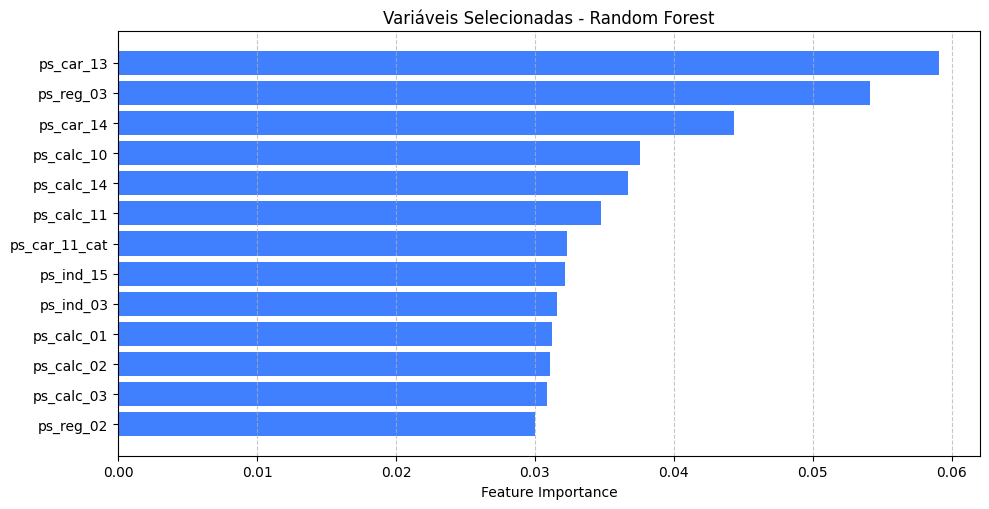

In [0]:
# Obter importância das variáveis
feature_importances = clf.feature_importances_
features = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=False)

# Estabelecer um limite de corte, por exemplo, x% da importância máxima
cutoff_maximp = 0.5

cutoff = cutoff_maximp * feature_importances.max()

# Selecionar variáveis acima do corte
selected_features = X.columns[feature_importances > cutoff].tolist()
print('Número de features selecionadas: ',len(selected_features))

# Ordenar variáveis por importância
features = features.sort_values(by='Importance', ascending=True)

# Filtrar o DataFrame para apenas as features acima do corte
selected_features_df = features[features['Importance'] > cutoff]

# Ajusta o tamanho da figura com base no número de features selecionadas
plt.figure(figsize=(10, len(selected_features_df)*0.4))

# Plota as features selecionadas
plt.barh(selected_features_df['Feature'], selected_features_df['Importance'], color=(0.25, 0.5, 1))
plt.xlabel("Feature Importance")
plt.title("Variáveis Selecionadas - Random Forest")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [0]:
import pickle
with open('/Volumes/workspace/data_science/medium/porto_seguro/artifacts/prd_list_features.pkl', 'wb') as f:
    pickle.dump(selected_features, f)

In [0]:
with open('/Volumes/workspace/data_science/medium/porto_seguro/artifacts/prd_list_features.pkl', 'rb') as f:
    loaded_lista = pickle.load(f)

print(loaded_lista)

['ps_ind_03', 'ps_ind_15', 'ps_reg_02', 'ps_reg_03', 'ps_car_11_cat', 'ps_car_13', 'ps_car_14', 'ps_calc_01', 'ps_calc_02', 'ps_calc_03', 'ps_calc_10', 'ps_calc_11', 'ps_calc_14']


In [0]:
lista_features = loaded_lista + ['target']
abt_train_01 = abt_train_0[lista_features]

abt_train_01.head()

,ps_ind_03,ps_ind_15,ps_reg_02,ps_reg_03,ps_car_11_cat,ps_car_13,ps_car_14,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_10,ps_calc_11,ps_calc_14,target
0,1.695565,0.761809,2.869279,2.551830e+00,1.265515,3.282777,0.933695,0.870596,1.570820,-0.869620,-0.493106,-0.189128,0.896386,0
1,-0.527733,0.479805,0.149555,-2.906527e-01,0.689777,-0.510640,0.517388,1.567305,0.873885,1.220110,-1.182005,-1.045842,1.624615,0
2,0.583916,-2.058230,2.374783,1.072055e+00,1.265515,-1.087392,0.416784,1.218950,-0.868451,1.220110,1.918039,-0.617485,0.896386,0
3,-0.157184,-0.366207,-0.839435,-3.550803e-16,-0.673815,-0.190735,0.152728,-1.219531,-1.565385,1.220110,0.195793,-0.189128,0.168156,0
4,-0.898283,-0.366207,0.149555,-4.247585e-01,-1.522272,0.075932,-1.134278,1.218950,-0.171516,1.568398,-1.526454,1.095943,-0.924188,1


In [0]:

abt_test_01 = abt_test_0[lista_features]
abt_test_01.head()

,ps_ind_03,ps_ind_15,ps_reg_02,ps_reg_03,ps_car_11_cat,ps_car_13,ps_car_14,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_10,ps_calc_11,ps_calc_14,target
0,0.213366,0.197801,2.374783,1.516008e+00,-1.401063,-0.963025,-2.787195e-02,-1.567885,-0.519983,-0.869620,-0.493106,0.667586,-1.652418,0
1,2.066114,-0.648211,2.374783,2.891407e+00,1.265515,1.890850,1.621810e+00,-0.522822,1.222352,-0.521332,0.195793,0.239229,-0.924188,0
2,1.695565,0.761809,-0.839435,-3.550803e-16,-0.946533,-1.186010,3.784268e-15,-0.871176,0.525418,-0.521332,1.229141,-1.045842,-0.195959,0
3,0.954465,-1.212218,2.127536,-8.148708e-02,1.053401,0.271939,-1.735980e+00,-0.174467,1.222352,-1.217908,-1.182005,-1.902556,-0.560074,0
4,-0.527733,1.325816,-0.097692,-4.885880e-01,-0.734419,-0.324480,-3.377311e-01,-1.567885,1.222352,1.568398,0.540242,0.239229,-0.560074,0


In [0]:
# Salvando abt para treinamento dos modelos

abt_train_01.to_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_fs01_train.csv')
abt_test_01.to_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_fs01_test.csv')

## Modelagem

Com os dados preparados, foram testados diferentes algoritmos de classificação amplamente utilizados em problemas tabulares e de risco.

- Regressão Logística (baseline)  
- Random Forest  
- XGBoost  
- LightGBM  
- CatBoost  

Os modelos foram avaliados utilizando GridSearch para ajuste de hiperparâmetros, tendo como métrica principal o ROC AUC, conforme o critério oficial da competição.

In [0]:
abt_train_02 = pd.read_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_fs01_train.csv', index_col=0)
abt_test_02 = pd.read_csv('/Volumes/workspace/data_science/medium/porto_seguro/arquivos/abt_fs01_test.csv', index_col=0)

abt_train_02.head()

,ps_ind_03,ps_ind_15,ps_reg_02,ps_reg_03,ps_car_11_cat,ps_car_13,ps_car_14,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_10,ps_calc_11,ps_calc_14,target
0,1.695565,0.761809,2.869279,2.551830e+00,1.265515,3.282777,0.933695,0.870596,1.570820,-0.869620,-0.493106,-0.189128,0.896386,0
1,-0.527733,0.479805,0.149555,-2.906527e-01,0.689777,-0.510640,0.517388,1.567305,0.873885,1.220110,-1.182005,-1.045842,1.624615,0
2,0.583916,-2.058230,2.374783,1.072055e+00,1.265515,-1.087392,0.416784,1.218950,-0.868451,1.220110,1.918039,-0.617485,0.896386,0
3,-0.157184,-0.366207,-0.839435,-3.550803e-16,-0.673815,-0.190735,0.152728,-1.219531,-1.565385,1.220110,0.195793,-0.189128,0.168156,0
4,-0.898283,-0.366207,0.149555,-4.247585e-01,-1.522272,0.075932,-1.134278,1.218950,-0.171516,1.568398,-1.526454,1.095943,-0.924188,1


In [0]:
#Verificando se o modelo está desbalanceado

abt_train_02.target.value_counts()

0    401539
1     15109
Name: target, dtype: int64

In [0]:
# Fazendo o undersampling controlado
evento = abt_train_02[abt_train_02['target'] == 1]
nevento = abt_train_02[abt_train_02['target'] == 0]

# Amostragem aleatória dos negativos
negativos_amostra = nevento.sample(n=len(evento),random_state=42)

# Concatenar as duas partes para obter a amostra balanceada
amostra_balanceada = pd.concat([evento, negativos_amostra])

# Embaralhar os dados, se desejado
amostra_balanceada = amostra_balanceada.sample(frac=1,random_state = 42).reset_index(drop=True)

amostra_balanceada.shape

(30218, 14)

In [0]:
amostra_balanceada.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30218 entries, 0 to 30217
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ps_ind_03      30218 non-null  float64
 1   ps_ind_15      30218 non-null  float64
 2   ps_reg_02      30218 non-null  float64
 3   ps_reg_03      30218 non-null  float64
 4   ps_car_11_cat  30218 non-null  float64
 5   ps_car_13      30218 non-null  float64
 6   ps_car_14      30218 non-null  float64
 7   ps_calc_01     30218 non-null  float64
 8   ps_calc_02     30218 non-null  float64
 9   ps_calc_03     30218 non-null  float64
 10  ps_calc_10     30218 non-null  float64
 11  ps_calc_11     30218 non-null  float64
 12  ps_calc_14     30218 non-null  float64
 13  target         30218 non-null  int64  
dtypes: float64(13), int64(1)
memory usage: 3.2 MB


In [0]:
# Separando as variáveis de entrada (features) e de saída (target)
X = amostra_balanceada.drop(columns=["target"])
y = amostra_balanceada["target"]

In [0]:
# Separando uma amostra de 70% para treinar o modelo e 30% para testar o modelo
# Holdout 70/30 (out-of-sample)

from sklearn.model_selection import train_test_split

# Dividindo os dados em conjunto de treinamento e teste (70% treino, 30% teste)
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=42)
X_train.shape,X_test.shape

((21152, 13), (9066, 13))

### Logistic Regression

A Regressão Logística foi utilizada como modelo de referência (baseline). Embora simples e interpretável, seus resultados mostram limitações claras na capacidade de discriminar entre motoristas com e sem sinistro.

A curva ROC permanece próxima da diagonal, indicando baixo poder discriminativo. O alto recall ocorre porque o modelo tende a classificar grande parte das observações como evento, comprometendo o ranqueamento do risco. As curvas Precision-Recall e os baixos valores de Gini e KS reforçam esse comportamento.

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
import numpy as np


# Definindo o modelo
model = LogisticRegression(max_iter=100)
model_sgs = LogisticRegression(max_iter=100)

# Definindo os parâmetros para o grid search
param_grid = {
    'penalty':['l1','l2'],
    'tol':[0.00001,0.0001,0.001],
    'C': [1.0, 2.0],
    'solver':['liblinear', 'saga'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 2, 1: 1}]
}


# Calculando a quantidade total de modelos que serão treinados
num_models = len(param_grid['penalty']) * len(param_grid['tol']) * len(param_grid['C']) * len(param_grid['solver']) * 5  # 5 é o número de folds na validação cruzada (cv)
print(f"Total de Modelos a serem Treinados: {num_models}")

# Definindo o objeto GridSearchCV
grid_rl = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc', 
                    n_jobs=-1)

# Treinando o modelo com o grid search
grid_rl.fit(X_train, y_train)

# treinando modelo sem grid search para comparra
model_sgs.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search
print("Melhores Parâmetros: ", grid_rl.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros
print("Melhor AUC: ", grid_rl.best_score_)

# Utilizando o melhor modelo para fazer previsões
prediction_rl = grid_rl.best_estimator_.predict(X_test)
predprob = grid_rl.best_estimator_.predict_proba(X_test)[:, 1]

best_model_rl = grid_rl.best_estimator_

# Cálculo do coeficiente de Gini
gini_rl = round(2 * roc_auc_score(y_test, predprob) - 1, 3)
print(f"Gini: {gini_rl}")

Total de Modelos a serem Treinados: 120
Melhores Parâmetros:  {'C': 1.0, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
Melhor AUC:  0.5992112375109113
Gini: 0.183


In [0]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score,precision_score, recall_score, f1_score

# Resultados Arvore de Decisão
print("\n🔹 Melhores Parâmetros: ", grid_rl.best_params_)
print("🔹 Melhor AUC (Cross-Validation): ", round(grid_rl.best_score_, 4))


# --- Métricas de avaliação ---
accuracy_rl = accuracy_score(y_test, prediction_rl)
precision_rl = precision_score(y_test, prediction_rl)
recall_rl = recall_score(y_test, prediction_rl)
f1_rl = f1_score(y_test, prediction_rl)
roc_auc_rl = grid_rl.best_score_
gini_rl = gini_rl

# --- Exibição dos resultados ---
print("\n📊 Resultados do Modelo XGBoost:")
print(f"Accuracy:  {accuracy_rl:.4f}")
print(f"Precision: {precision_rl:.4f}")
print(f"Recall:    {recall_rl:.4f}")
print(f"F1-Score:  {f1_rl:.4f}")
print(f"ROC AUC:   {roc_auc_rl:.4f}")
print(f"Gini:      {gini_rl:.4f}")

# Guardando o melhor modelo
best_model_rl = grid_rl.best_estimator_



🔹 Melhores Parâmetros:  {'C': 1.0, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l1', 'solver': 'liblinear', 'tol': 0.001}
🔹 Melhor AUC (Cross-Validation):  0.5992

📊 Resultados do Modelo XGBoost:
Accuracy:  0.5033
Precision: 0.5021
Recall:    0.9987
F1-Score:  0.6682
ROC AUC:   0.5992
Gini:      0.1830


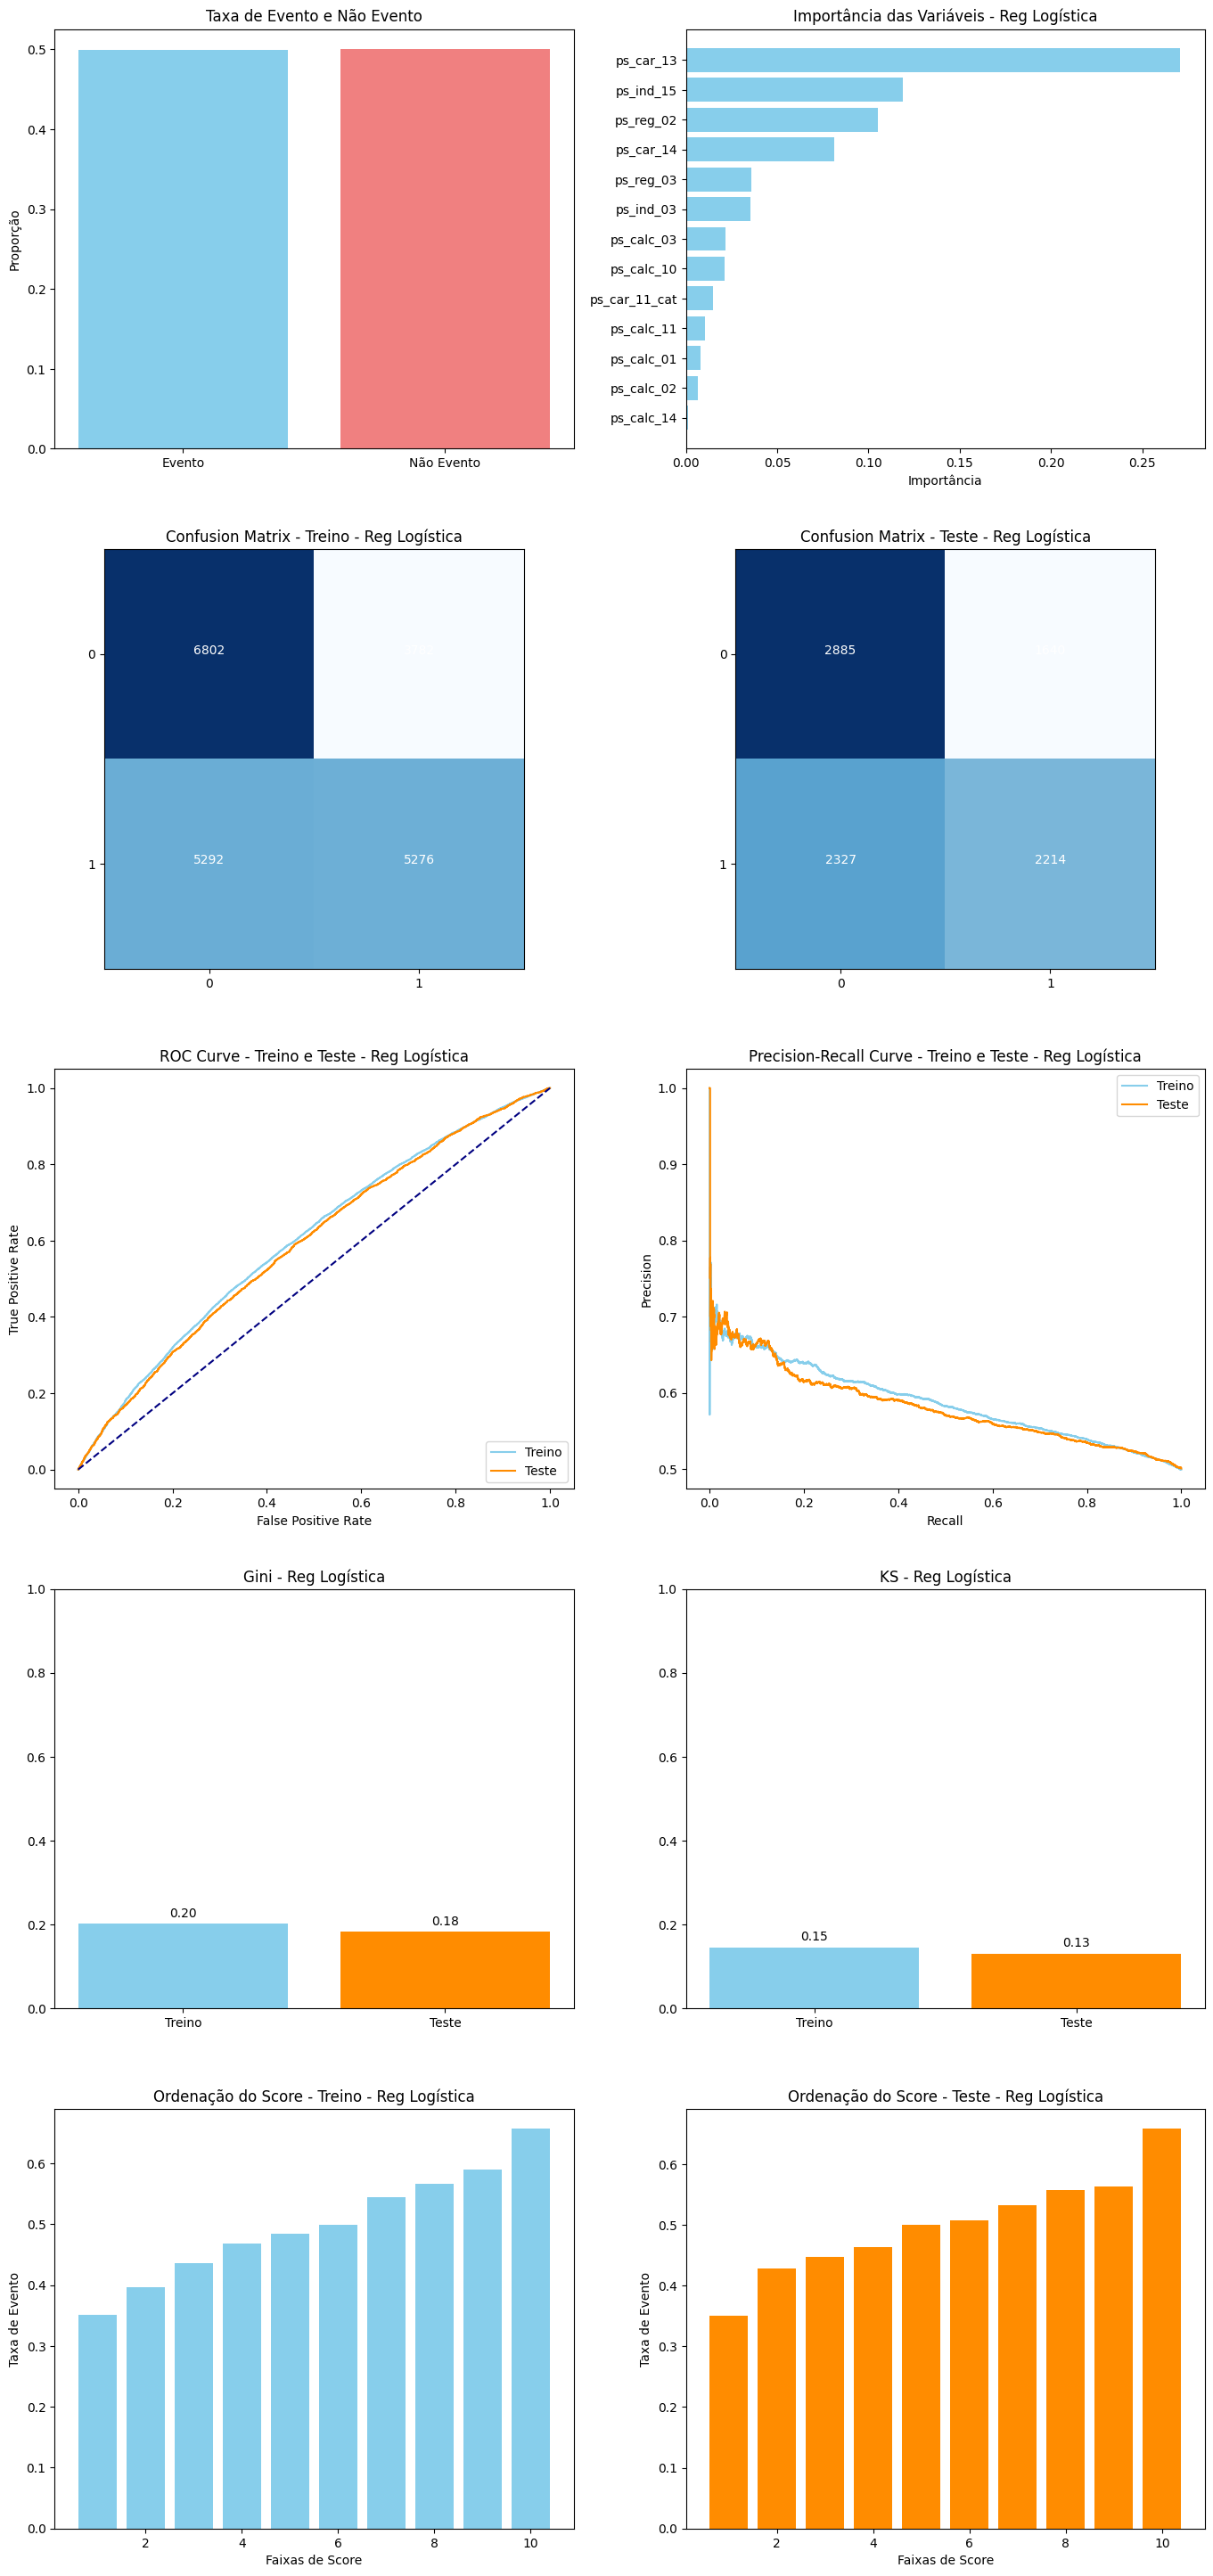

In [0]:

fun.avaliar_modelo(X_train, y_train, X_test, y_test, model_sgs,nm_modelo='Reg Logística')

### Random Forest

### Random Forest

O Random Forest apresentou excelente desempenho no conjunto de treino, com curvas ROC bem acima da aleatoriedade e boa separação entre decis.

No entanto, ao ser avaliado no conjunto de validação, ocorreu uma queda significativa de desempenho. Essa diferença entre treino e validação indica overfitting, sugerindo que o modelo aprendeu padrões específicos da base de treino, mas não conseguiu generalizar bem para dados não vistos.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Definindo o modelo
modelo_FDC = RandomForestClassifier(random_state=42)

# Grid Search reduzido (mais rápido)
param_grid_rf = {
    "n_estimators": [100, 200],
    "max_depth": [5, 8, 12],
    "min_samples_split": [10, 20],
    "min_samples_leaf": [5, 10, 20],
    "max_features": ["sqrt", 0.5],
    "class_weight": ["balanced_subsample"],
    "bootstrap": [True]
}

# Grid Search
grid_FDC = GridSearchCV(
    estimator=modelo_FDC,
    param_grid=param_grid_rf,
    cv=3,                    
    scoring='roc_auc',
    n_jobs=-1,                
    verbose=2
)

# Treinando o modelo
grid_FDC.fit(X_train, y_train)

# Resultados
print("Melhores Parâmetros: ", grid_FDC.best_params_)
print("Melhor AUC: ", grid_FDC.best_score_)

# Previsões
predictions_RF = grid_FDC.best_estimator_.predict(X_test)
predprob_RF = grid_FDC.best_estimator_.predict_proba(X_test)

# Gini normalizado
gini_RF = round(fun.gini_normalizado(y_test, predprob_RF[:, 1]), 2)
print('Gini normalizado --> ', gini_RF)

# Guardando o melhor modelo
best_model_rf = grid_FDC.best_estimator_

In [0]:
# Resultados Random Forest
print("\n🔹 Melhores Parâmetros: ", grid_FDC.best_params_)
print("🔹 Melhor AUC (Cross-Validation): ", round(grid_FDC.best_score_, 4))


# --- Métricas de avaliação ---
accuracy_RF = accuracy_score(y_test, predictions_RF)
precision_RF = precision_score(y_test, predictions_RF)
recall_RF = recall_score(y_test, predictions_RF)
f1_RF = f1_score(y_test, predictions_RF)
roc_auc_RF = grid_FDC.best_score_

# --- Exibição dos resultados ---
print("\n📊 Resultados do Modelo Random Forest:")
print(f"Accuracy:  {accuracy_RF:.4f}")
print(f"Precision: {precision_RF:.4f}")
print(f"Recall:    {recall_RF:.4f}")
print(f"F1-Score:  {f1_RF:.4f}")
print(f"ROC AUC:   {roc_auc_RF:.4f}")
print(f"Gini:      {gini_RF:.4f}")



🔹 Melhores Parâmetros:  {'bootstrap': True, 'class_weight': 'balanced_subsample', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 20, 'min_samples_split': 10, 'n_estimators': 200}
🔹 Melhor AUC (Cross-Validation):  0.6052

📊 Resultados do Modelo Random Forest:
Accuracy:  0.5683
Precision: 0.5699
Recall:    0.5627
F1-Score:  0.5663
ROC AUC:   0.6052
Gini:      0.2000


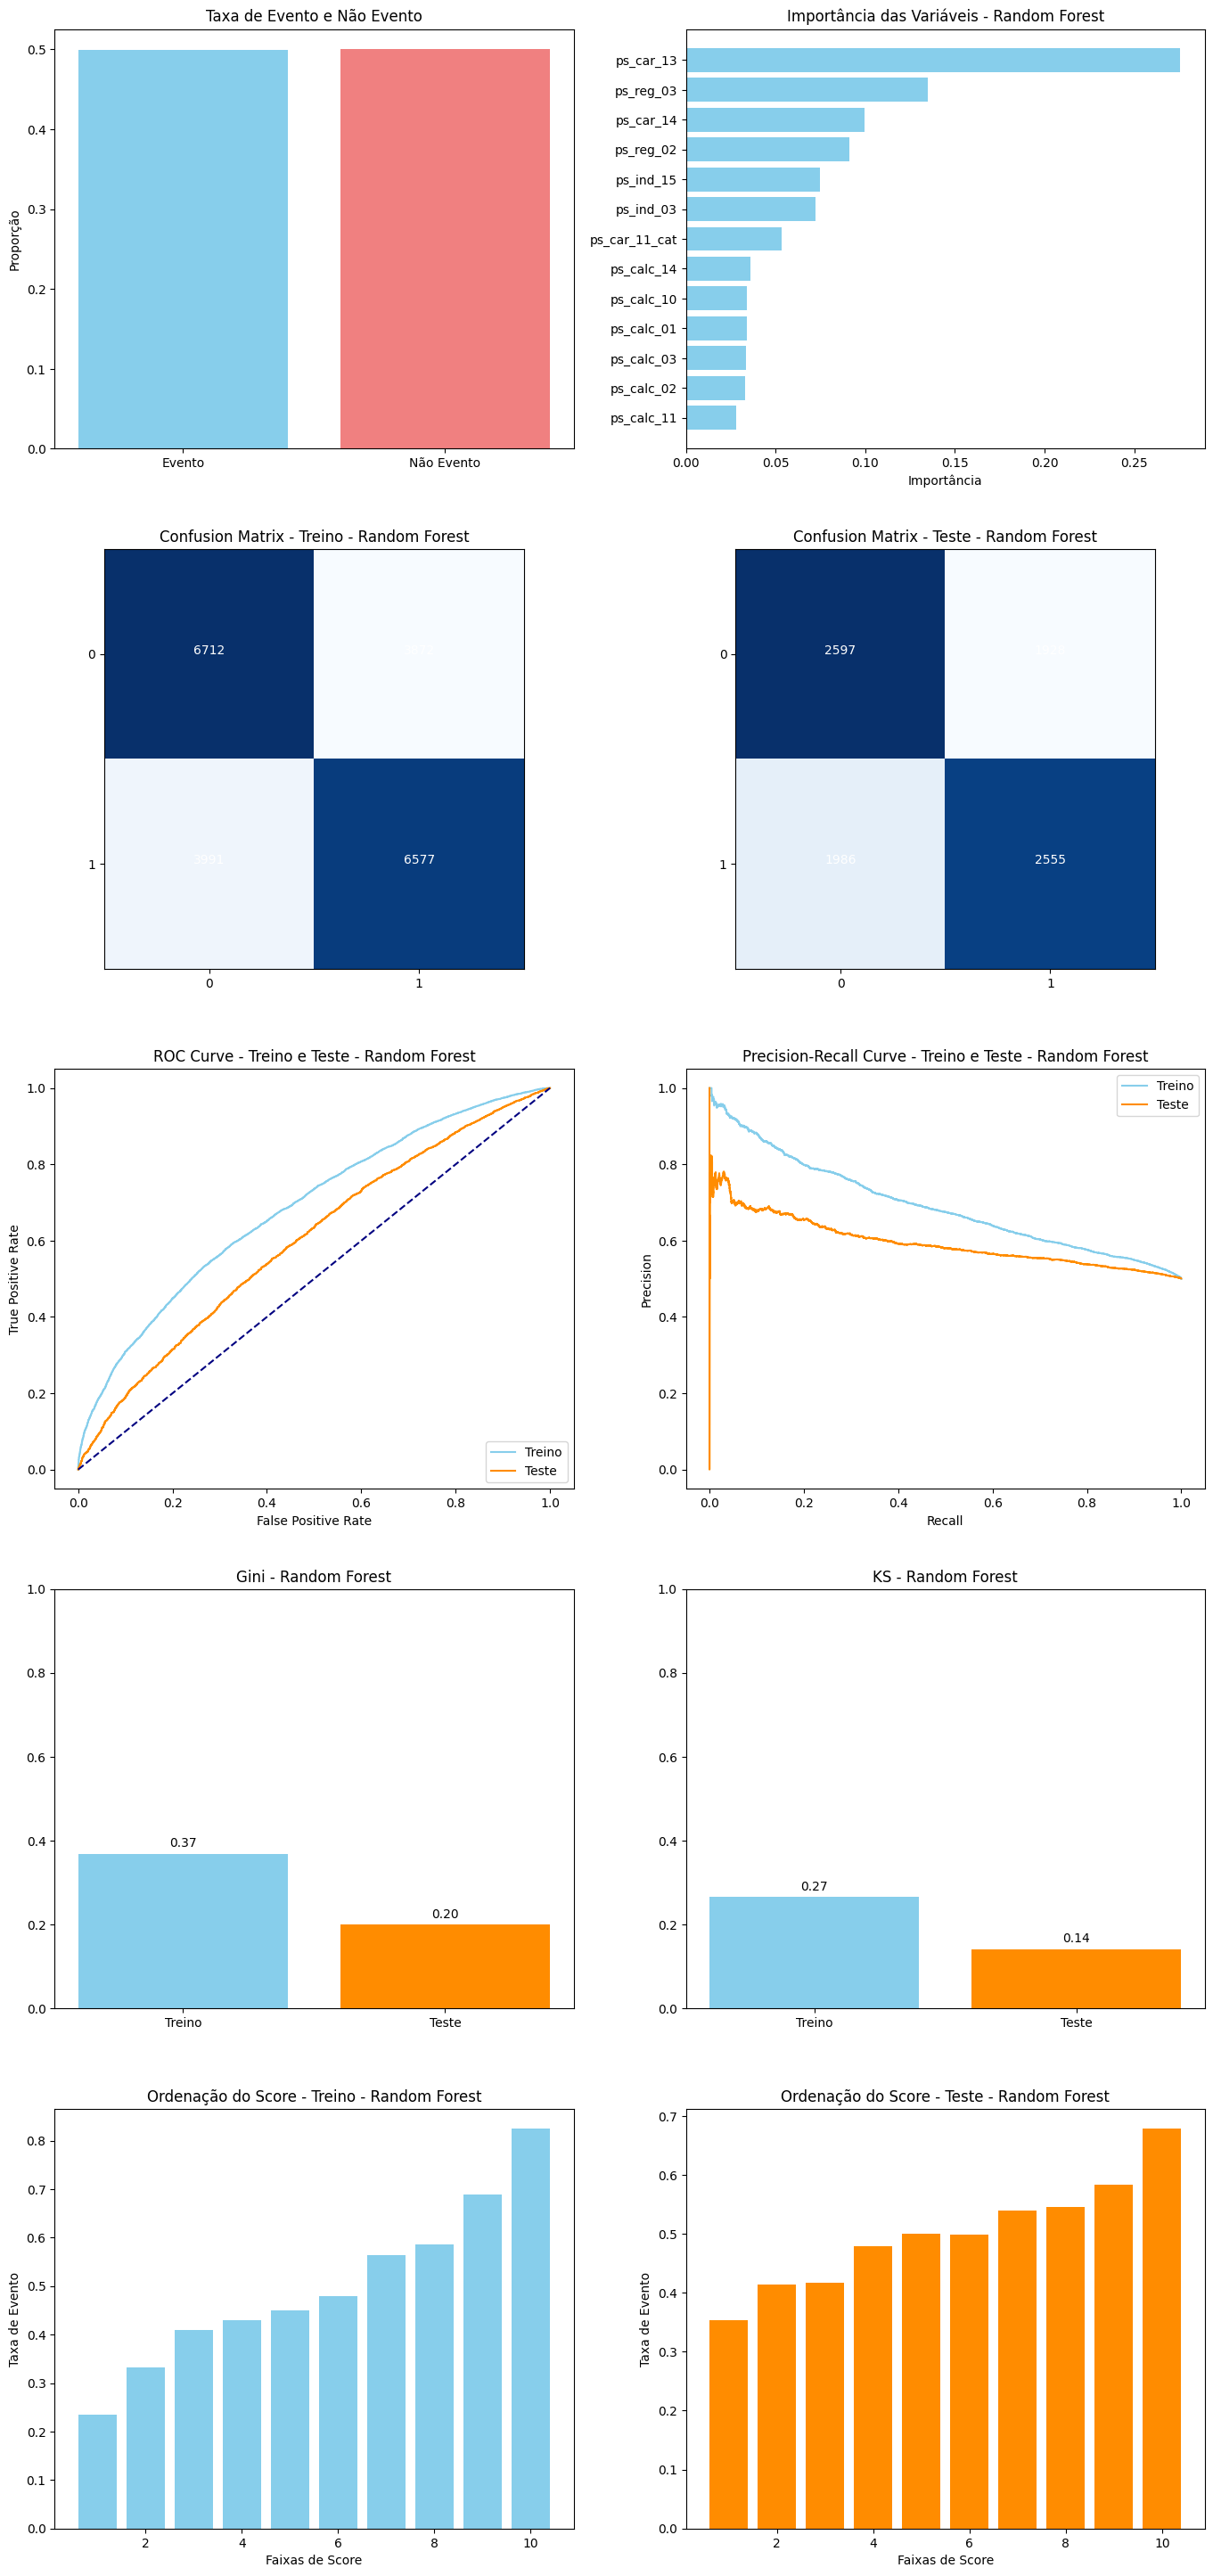

In [0]:
fun.avaliar_modelo(X_train, y_train,X_test, y_test,best_model_rf, nm_modelo='Random Forest')

### XGBoost

Os modelos de boosting apresentaram maior estabilidade em relação aos modelos anteriores. As curvas de treino e validação permaneceram próximas, indicando melhor controle de overfitting.

O XGBoost alcançou um dos melhores valores de AUC e Gini do experimento, enquanto o LightGBM apresentou desempenho semelhante, com métricas equilibradas e boa capacidade de generalização. Ainda assim, a ordenação de score apresentou sobreposição entre faixas, limitando o ranqueamento mais fino do risco.

In [0]:
!pip install xgboost

In [0]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Definindo o modelo
modelo_XGB = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Calculate pos and neg for scale_pos_weight
pos = y_train.sum()
neg = len(y_train) - pos

# Grid Search
param_grid = {
    "n_estimators": [300, 600],
    "learning_rate": [0.03, 0.05],
    "max_depth": [2, 3, 4],
    "subsample": [0.7, 0.85],
    "colsample_bytree": [0.6, 0.85],
    "gamma": [0, 0.5, 1],
    "min_child_weight": [1, 5]
}

# Definindo o Grid Search
grid_XGB = GridSearchCV(
    estimator=modelo_XGB,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,               
    verbose=2
)

# Treinando o modelo
grid_XGB.fit(X_train, y_train)

# Resultados
print("Melhores Parâmetros: ", grid_XGB.best_params_)
print("Melhor AUC: ", grid_XGB.best_score_)

# Previsões
predictions_XGB = grid_XGB.best_estimator_.predict(X_test)
predprob_XGB = grid_XGB.best_estimator_.predict_proba(X_test)

# Gini normalizado
gini_XGB = round(fun.gini_normalizado(y_test, predprob_XGB[:, 1]), 2)
print('Gini normalizado --> ', gini_XGB)

# Guardando o melhor modelo
best_model_xgb = grid_XGB.best_estimator_

In [0]:
# Resultados XGBoost
print("\n🔹 Melhores Parâmetros: ", grid_XGB.best_params_)
print("🔹 Melhor AUC (Cross-Validation): ", round(grid_XGB.best_score_, 4))


# --- Métricas de avaliação ---
accuracy_XGB = accuracy_score(y_test, predictions_XGB)
precision_XGB = precision_score(y_test, predictions_XGB)
recall_XGB = recall_score(y_test, predictions_XGB)
f1_XGB = f1_score(y_test, predictions_XGB)
roc_auc_XGB = grid_XGB.best_score_

# --- Exibição dos resultados ---
print("\n📊 Resultados do Modelo XGBoost:")
print(f"Accuracy:  {accuracy_XGB:.4f}")
print(f"Precision: {precision_XGB:.4f}")
print(f"Recall:    {recall_XGB:.4f}")
print(f"F1-Score:  {f1_XGB:.4f}")
print(f"ROC AUC:   {roc_auc_XGB:.4f}")
print(f"Gini:      {gini_XGB:.4f}")

# Guardando o melhor modelo
best_model_xgb = grid_XGB.best_estimator_



🔹 Melhores Parâmetros:  {'colsample_bytree': 0.6, 'gamma': 0.5, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.7}
🔹 Melhor AUC (Cross-Validation):  0.6107

📊 Resultados do Modelo XGBoost:
Accuracy:  0.5767
Precision: 0.5805
Recall:    0.5585
F1-Score:  0.5692
ROC AUC:   0.6107
Gini:      0.2200


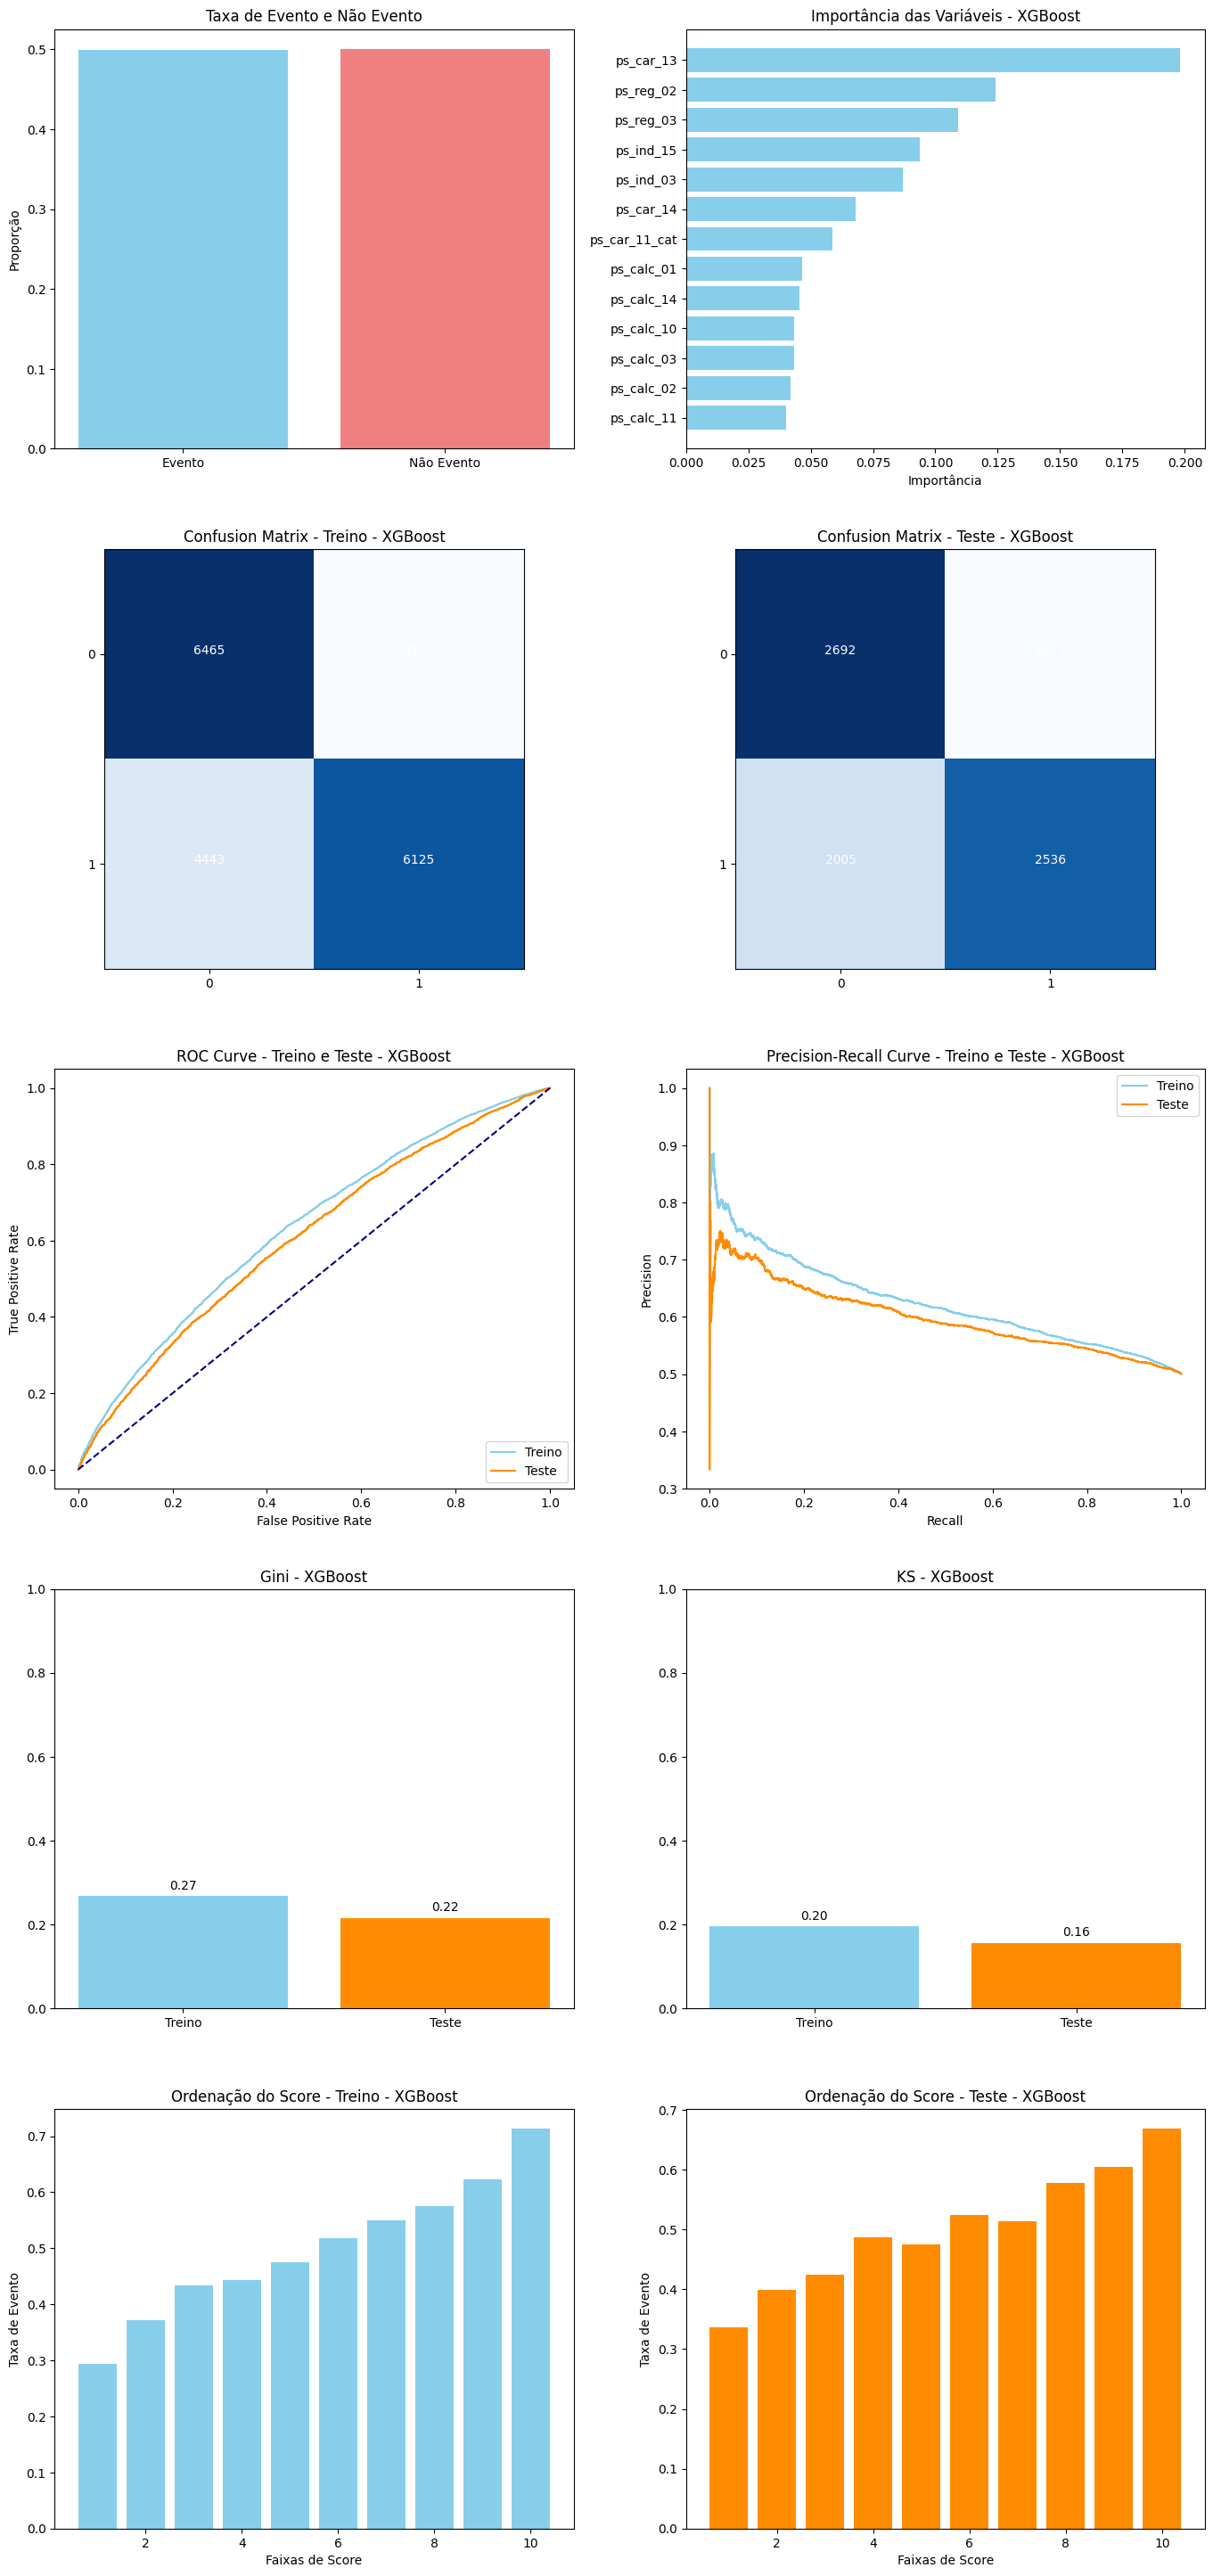

In [0]:
fun.avaliar_modelo(X_train, y_train,X_test, y_test,best_model_xgb, nm_modelo='XGBoost')

### LightGBM

In [0]:
!pip install lightgbm

In [0]:
# @title
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

# Definindo o modelo
modelo_LGB = lgb.LGBMClassifier(random_state=42)

# Grid Search 
param_grid_lgbm = {
    "max_depth": [-1, 6, 8],
    "num_leaves": [31, 63],
    "min_data_in_leaf": [30, 80],

    "learning_rate": [0.01, 0.03],
    "n_estimators": [800, 1600],

    "feature_fraction": [0.7, 0.85],
    "bagging_fraction": [0.7, 0.85],
    "bagging_freq": [1],

    "min_gain_to_split": [0.0, 0.1],
    "lambda_l1": [0.0, 0.1],
    "lambda_l2": [1, 5],
}


# Definindo o Grid Search
grid_LGB = GridSearchCV(
    estimator=modelo_LGB,
    param_grid=param_grid,
    cv=3,                    # reduzido de 5 para 3 folds
    scoring='roc_auc',
    n_jobs=-1,               # usa todos os núcleos disponíveis
    verbose=2
)

# Treinando o modelo
grid_LGB.fit(X_train, y_train)

# Resultados
print("Melhores Parâmetros: ", grid_LGB.best_params_)
print("Melhor AUC: ", grid_LGB.best_score_)

# Previsões
predictions_LGBM = grid_LGB.best_estimator_.predict(X_test)
predprob = grid_LGB.best_estimator_.predict_proba(X_test)

# Gini normalizado (mesmo método do XGBoost)
gini_LGBM = round(fun.gini_normalizado(y_test, predprob[:, 1]), 2)
print('Gini normalizado --> ', gini_LGBM)

# Guardando o melhor modelo
best_model_lgb = grid_LGB.best_estimator_

In [0]:

# Resultados LightGBM
print("\n🔹 Melhores Parâmetros: ", grid_LGB.best_params_)
print("🔹 Melhor AUC (Cross-Validation): ", round(grid_LGB.best_score_, 4))


# --- Métricas de avaliação ---
accuracy_LGB = accuracy_score(y_test, predictions_LGBM)
precision_LGB = precision_score(y_test, predictions_LGBM)
recall_LGB = recall_score(y_test, predictions_LGBM)
f1_LGB = f1_score(y_test, predictions_LGBM)
roc_auc_LGB = grid_LGB.best_score_

# --- Exibição dos resultados ---
print("\n📊 Resultados do Modelo XGBoost:")
print(f"Accuracy:  {accuracy_LGB:.4f}")
print(f"Precision: {precision_LGB:.4f}")
print(f"Recall:    {recall_LGB:.4f}")
print(f"F1-Score:  {f1_LGB:.4f}")
print(f"ROC AUC:   {roc_auc_LGB:.4f}")
print(f"Gini:      {gini_LGBM:.4f}")

# Guardando o melhor modelo
best_model_lgb = grid_LGB.best_estimator_



🔹 Melhores Parâmetros:  {'colsample_bytree': 0.6, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 300, 'subsample': 0.7}
🔹 Melhor AUC (Cross-Validation):  0.6091

📊 Resultados do Modelo XGBoost:
Accuracy:  0.5727
Precision: 0.5760
Recall:    0.5565
F1-Score:  0.5661
ROC AUC:   0.6091
Gini:      0.2100


[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma
[LightGBM] [Warning] Unknown parameter: gamma


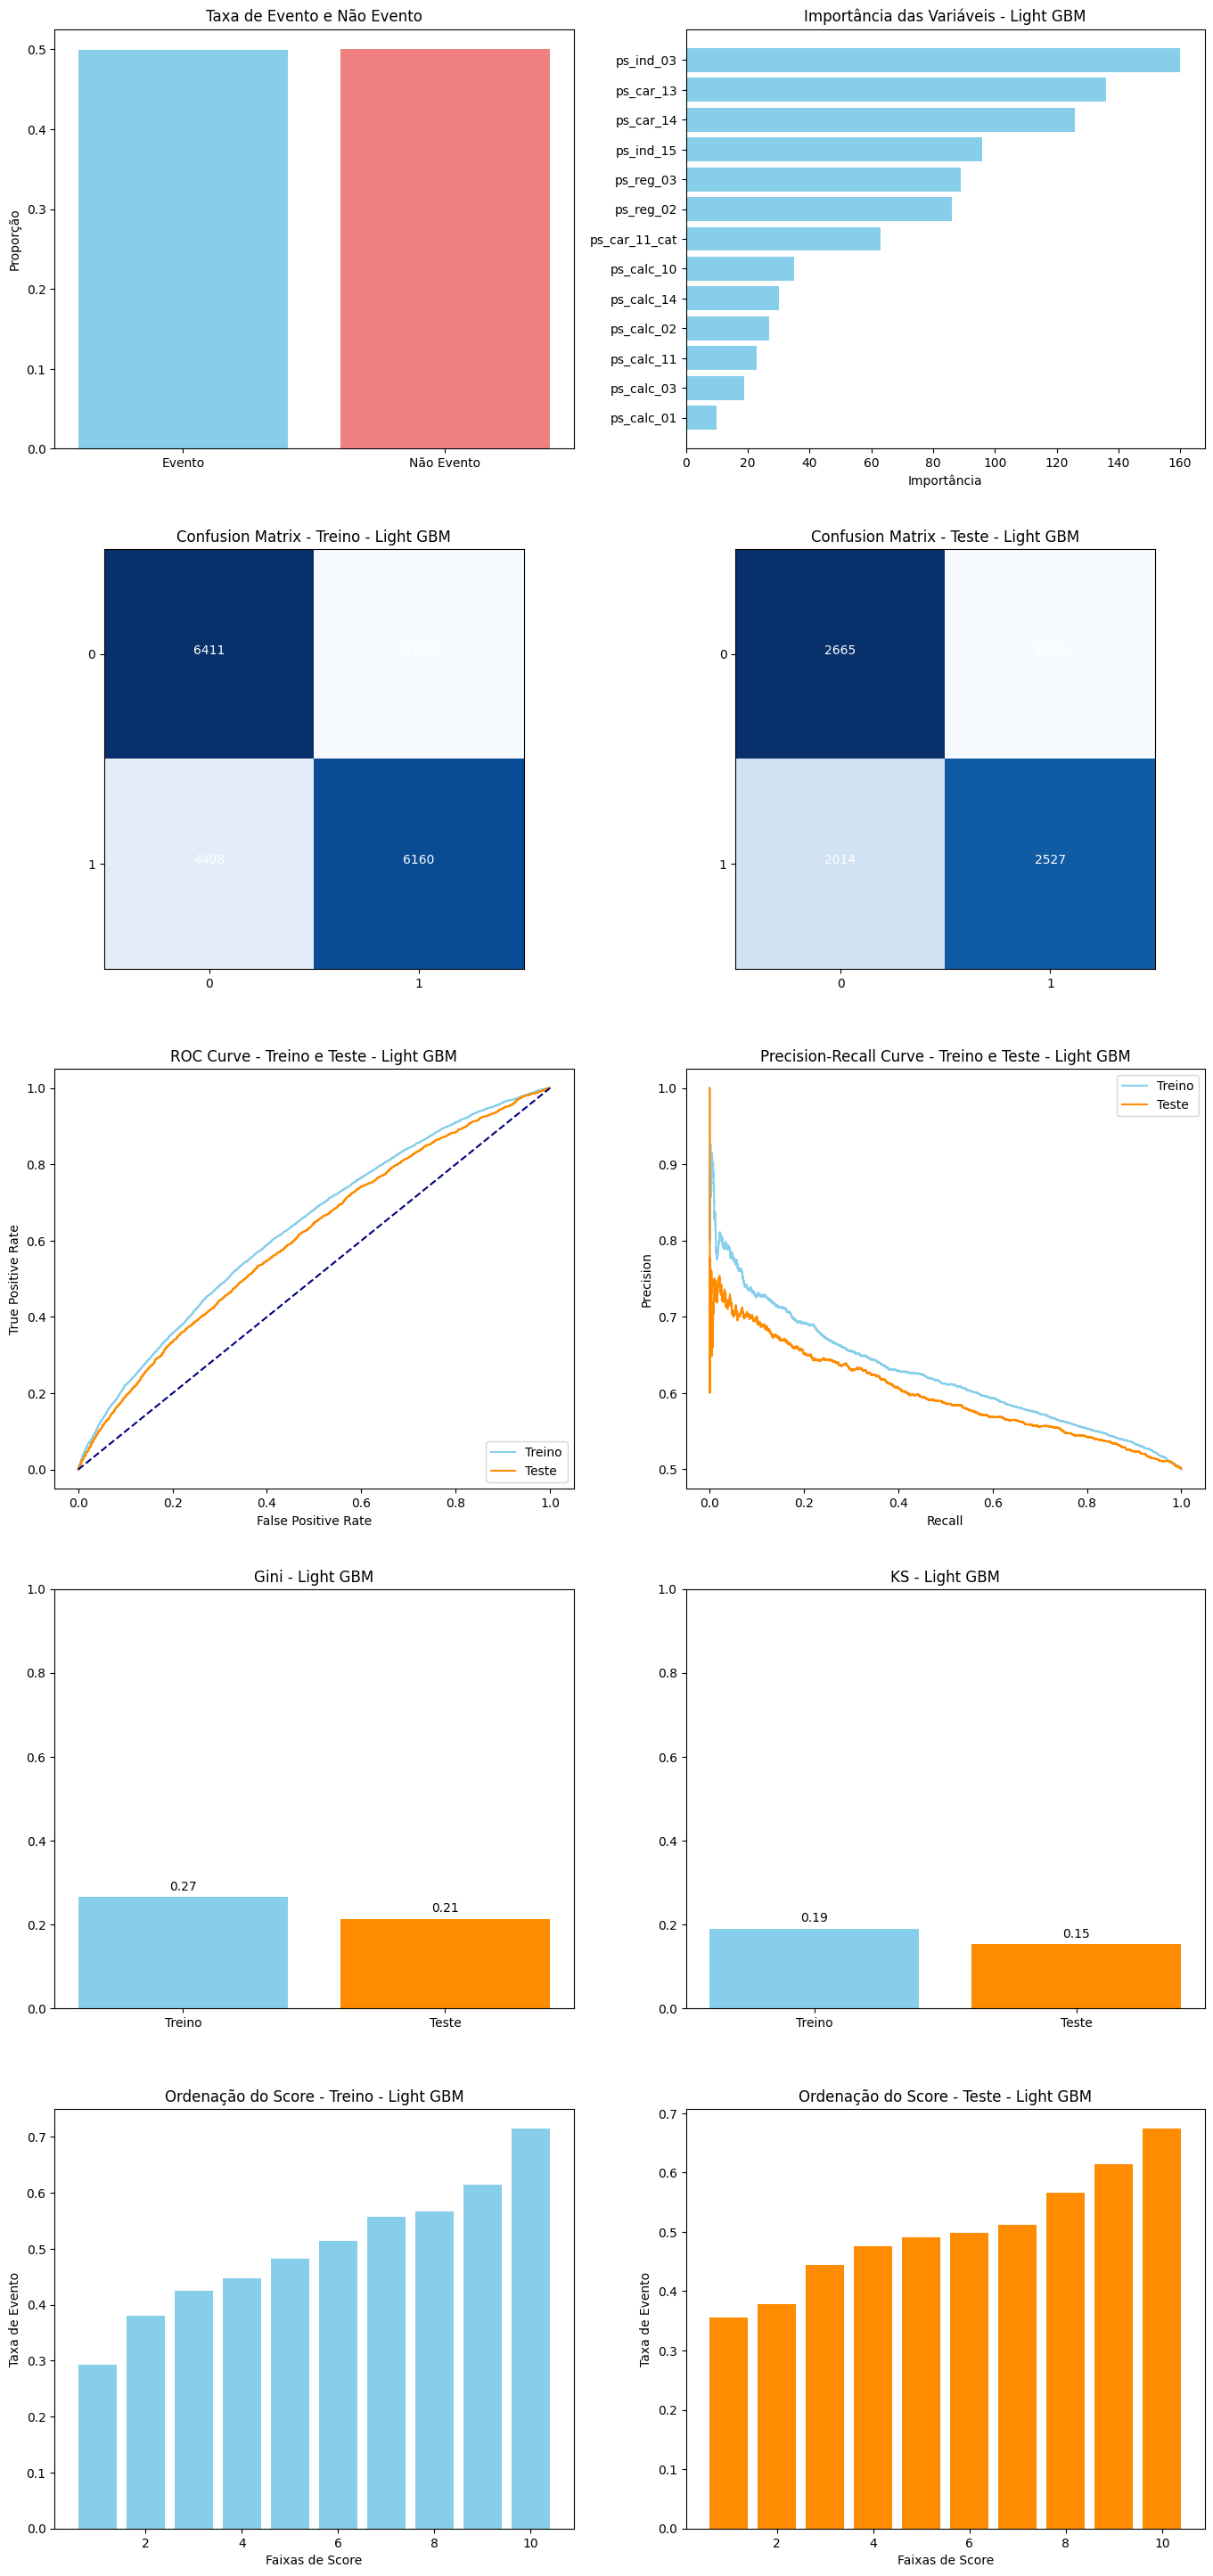

In [0]:
fun.avaliar_modelo(X_train, y_train,X_test, y_test,best_model_lgb, nm_modelo='Light GBM')

### CatBoost

### CatBoost

O CatBoost se destacou como o modelo mais equilibrado do estudo. Ele apresentou o maior ROC AUC e o maior Gini, mantendo curvas de treino e validação bem alinhadas.

Embora exista um leve distanciamento na curva Precision-Recall, esse efeito é significativamente menor do que o observado no Random Forest. A ordenação de score mostrou-se mais estável, com menor instabilidade entre decis.

In [0]:
!pip install catboost

In [0]:
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_auc_score
import numpy as np

# --- identificar categóricas
cat_cols = [c for c in X_train.columns if c.endswith("_cat")]
cat_idx  = [X_train.columns.get_loc(c) for c in cat_cols]

# --- converter cat cols para string (treino e teste)
X_train_cb = X_train.copy()
X_test_cb  = X_test.copy()

X_train_cb[cat_cols] = X_train_cb[cat_cols].astype("string").fillna("NA")
X_test_cb[cat_cols]  = X_test_cb[cat_cols].astype("string").fillna("NA")

# --- modelo
model = CatBoostClassifier(
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=42,
    verbose=0,
    auto_class_weights="Balanced",
    allow_writing_files=False
)

param_grid = {
    "learning_rate": [0.01, 0.03, 0.05],
    "depth": [4, 6, 8],
    "l2_leaf_reg": [3, 5, 10],
    "iterations": [800, 1600]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_cat = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    cv=cv,
    verbose=2,
    scoring="roc_auc",
    n_jobs=-1
)

# --- fit (mantido)
grid_cat.fit(X_train_cb, y_train, cat_features=cat_idx)

print("Melhores Parâmetros:", grid_cat.best_params_)
print("Melhor AUC (CV):", grid_cat.best_score_)

best_model_cat = grid_cat.best_estimator_

predprob = best_model_cat.predict_proba(X_test_cb)[:, 1]

auc_test = roc_auc_score(y_test, predprob)
gini_test = 2 * auc_test - 1

print("AUC Teste:", round(auc_test, 6))
print("Gini Teste:", round(gini_test, 6))

In [0]:
predictions_cat = grid_cat.best_estimator_.predict(X_test_cb)

In [0]:
# Resultados CatBoost
print("\n🔹 Melhores Parâmetros: ", grid_cat.best_params_)
print("🔹 Melhor AUC (Cross-Validation): ", round(grid_cat.best_score_, 4))


# --- Métricas de avaliação ---
accuracy_Cat = accuracy_score(y_test, predictions_cat)
precision_Cat = precision_score(y_test, predictions_cat)
recall_Cat = recall_score(y_test, predictions_cat)
f1_Cat = f1_score(y_test, predictions_cat)
roc_auc_Cat = grid_cat.best_score_

# --- Exibição dos resultados ---
print("\n📊 Resultados do Modelo CatBoost:")
print(f"Accuracy:  {accuracy_Cat:.4f}")
print(f"Precision: {precision_Cat:.4f}")
print(f"Recall:    {recall_Cat:.4f}")
print(f"F1-Score:  {f1_Cat:.4f}")
print(f"ROC AUC:   {roc_auc_Cat:.4f}")
print(f"Gini:      {gini_test:.4f}")

# Guardando o melhor modelo
best_model_cat = grid_cat.best_estimator_



🔹 Melhores Parâmetros:  {'depth': 4, 'iterations': 1600, 'l2_leaf_reg': 10, 'learning_rate': 0.01}
🔹 Melhor AUC (Cross-Validation):  0.6144

📊 Resultados do Modelo CatBoost:
Accuracy:  0.5777
Precision: 0.5803
Recall:    0.5666
F1-Score:  0.5734
ROC AUC:   0.6144
Gini:      0.2216


In [0]:
def avaliar_modelo(X_train, y_train, X_test, y_test, modelo, nm_modelo):
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import itertools
    from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, roc_auc_score

    def calcular_ks_statistic(y_true, y_score):
        df = pd.DataFrame({'y_true': y_true, 'y_score': y_score})
        df = df.sort_values(by='y_score', ascending=False).reset_index(drop=True)

        total_events = df['y_true'].sum()
        total_non_events = len(df) - total_events

        cumulative_events = df['y_true'].cumsum()
        cumulative_non_events = (1 - df['y_true']).cumsum()

        tpr = cumulative_events / total_events if total_events > 0 else np.zeros(len(df))
        fpr = cumulative_non_events / total_non_events if total_non_events > 0 else np.zeros(len(df))

        ks_statistic = np.max(np.abs(tpr - fpr))
        return ks_statistic

    feature_names = list(X_train.columns)
    # Criação da figura e dos eixos
    fig, axs = plt.subplots(5, 2, figsize=(15, 30))  # Ajustado para incluir novos gráficos
    plt.tight_layout(pad=6.0)

    # Cor azul claro
    cor = 'skyblue'

    # Taxa de Evento e Não Evento
    event_rate = np.mean(y_train)
    non_event_rate = 1 - event_rate
    axs[0, 0].bar(['Evento', 'Não Evento'], [event_rate, non_event_rate], color=[cor, 'lightcoral'])
    axs[0, 0].set_title('Taxa de Evento e Não Evento')
    axs[0, 0].set_ylabel('Proporção')

    # Importância dos Atributos
 # Importância dos Atributos (suporta sklearn e CatBoost)
    importancias = None

# CatBoost: usar get_feature_importance
    if hasattr(modelo, "get_feature_importance"):
      try:
        # Melhor: baseado no impacto real na predição (mais interpretável)
        importancias = modelo.get_feature_importance(type="PredictionValuesChange")
      except:
        # fallback
        importancias = modelo.get_feature_importance()
    elif hasattr(modelo, "coef_"):
      importancias = np.abs(modelo.coef_[0])
    elif hasattr(modelo, "feature_importances_"):
      importancias = modelo.feature_importances_

    if importancias is not None:
      importancias_df = pd.DataFrame({"feature": feature_names, "importance": importancias})
      importancias_df = importancias_df.sort_values(by="importance", ascending=True)

      axs[0, 1].barh(importancias_df["feature"], importancias_df["importance"], color=cor)
      axs[0, 1].set_title("Importância das Variáveis - " + nm_modelo)
      axs[0, 1].set_xlabel("Importância")
    else:
      axs[0, 1].axis("off")

    # Confusion Matrix - Treino
    y_pred_train = modelo.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    axs[1, 0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 0].set_title('Confusion Matrix - Treino - ' + nm_modelo)
    axs[1, 0].set_xticks([0, 1])
    axs[1, 0].set_yticks([0, 1])
    axs[1, 0].set_xticklabels(['0', '1'])
    axs[1, 0].set_yticklabels(['0', '1'])
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        axs[1, 0].text(j, i, format(cm_train[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")

    # Confusion Matrix - Teste
    y_pred_test = modelo.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    axs[1, 1].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 1].set_title('Confusion Matrix - Teste - ' + nm_modelo)
    axs[1, 1].set_xticks([0, 1])
    axs[1, 1].set_yticks([0, 1])
    axs[1, 1].set_xticklabels(['0', '1'])
    axs[1, 1].set_yticklabels(['0', '1'])
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        axs[1, 1].text(j, i, format(cm_test[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")

    # ROC Curve - Treino e Teste
    y_score_train = modelo.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    axs[2, 0].plot(fpr_train, tpr_train, color=cor, label='Treino')

    y_score_test = modelo.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    axs[2, 0].plot(fpr_test, tpr_test, color='darkorange', label='Teste')

    axs[2, 0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[2, 0].set_title('ROC Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 0].set_xlabel('False Positive Rate')
    axs[2, 0].set_ylabel('True Positive Rate')
    axs[2, 0].legend(loc="lower right")

    # Precision-Recall Curve - Treino e Teste
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_score_train)
    axs[2, 1].plot(recall_train, precision_train, color=cor, label='Treino')

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_score_test)
    axs[2, 1].plot(recall_test, precision_test, color='darkorange', label='Teste')

    axs[2, 1].set_title('Precision-Recall Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 1].set_xlabel('Recall')
    axs[2, 1].set_ylabel('Precision')
    axs[2, 1].legend(loc="upper right")

    # Gini - Treino e Teste
    auc_train = roc_auc_score(y_train, y_score_train)
    gini_train = 2 * auc_train - 1
    auc_test = roc_auc_score(y_test, y_score_test)
    gini_test = 2 * auc_test - 1
    axs[3, 0].bar(['Treino', 'Teste'], [gini_train, gini_test], color=[cor, 'darkorange'])
    axs[3, 0].set_title('Gini - ' + nm_modelo)
    axs[3, 0].set_ylim(0, 1)
    axs[3, 0].text('Treino', gini_train + 0.01, f'{gini_train:.2f}', ha='center', va='bottom')
    axs[3, 0].text('Teste', gini_test + 0.01, f'{gini_test:.2f}', ha='center', va='bottom')

    # KS - Treino e Teste
    ks_train = calcular_ks_statistic(y_train, y_score_train)
    ks_test = calcular_ks_statistic(y_test, y_score_test)
    axs[3, 1].bar(['Treino', 'Teste'], [ks_train, ks_test], color=[cor, 'darkorange'])
    axs[3, 1].set_title('KS - ' + nm_modelo)
    axs[3, 1].set_ylim(0, 1)
    axs[3, 1].text('Treino', ks_train + 0.01, f'{ks_train:.2f}', ha='center', va='bottom')
    axs[3, 1].text('Teste', ks_test + 0.01, f'{ks_test:.2f}', ha='center', va='bottom')


    # Decile Analysis - Teste
    scores = modelo.predict_proba(X_test)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores.shape)  # Adiciona um pequeno ruído
    scores += noise
    deciles = pd.qcut(scores, q=10, duplicates='drop')
    decile_analysis = y_test.groupby(deciles).mean()
    axs[4, 1].bar(range(1, len(decile_analysis) + 1), decile_analysis, color='darkorange')
    axs[4, 1].set_title('Ordenação do Score - Teste - ' + nm_modelo)
    axs[4, 1].set_xlabel('Faixas de Score')
    axs[4, 1].set_ylabel('Taxa de Evento')

    # Decile Analysis - Treino
    scores_train = modelo.predict_proba(X_train)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores_train.shape)  # Adiciona um pequeno ruído
    scores_train += noise
    deciles_train = pd.qcut(scores_train, q=10, duplicates='drop')
    decile_analysis_train = y_train.groupby(deciles_train).mean()
    axs[4, 0].bar(range(1, len(decile_analysis_train) + 1), decile_analysis_train, color=cor)
    axs[4, 0].set_title('Ordenação do Score - Treino - ' + nm_modelo)
    axs[4, 0].set_xlabel('Faixas de Score')
    axs[4, 0].set_ylabel('Taxa de Evento')

    # Mostrar os gráficos
    plt.show()

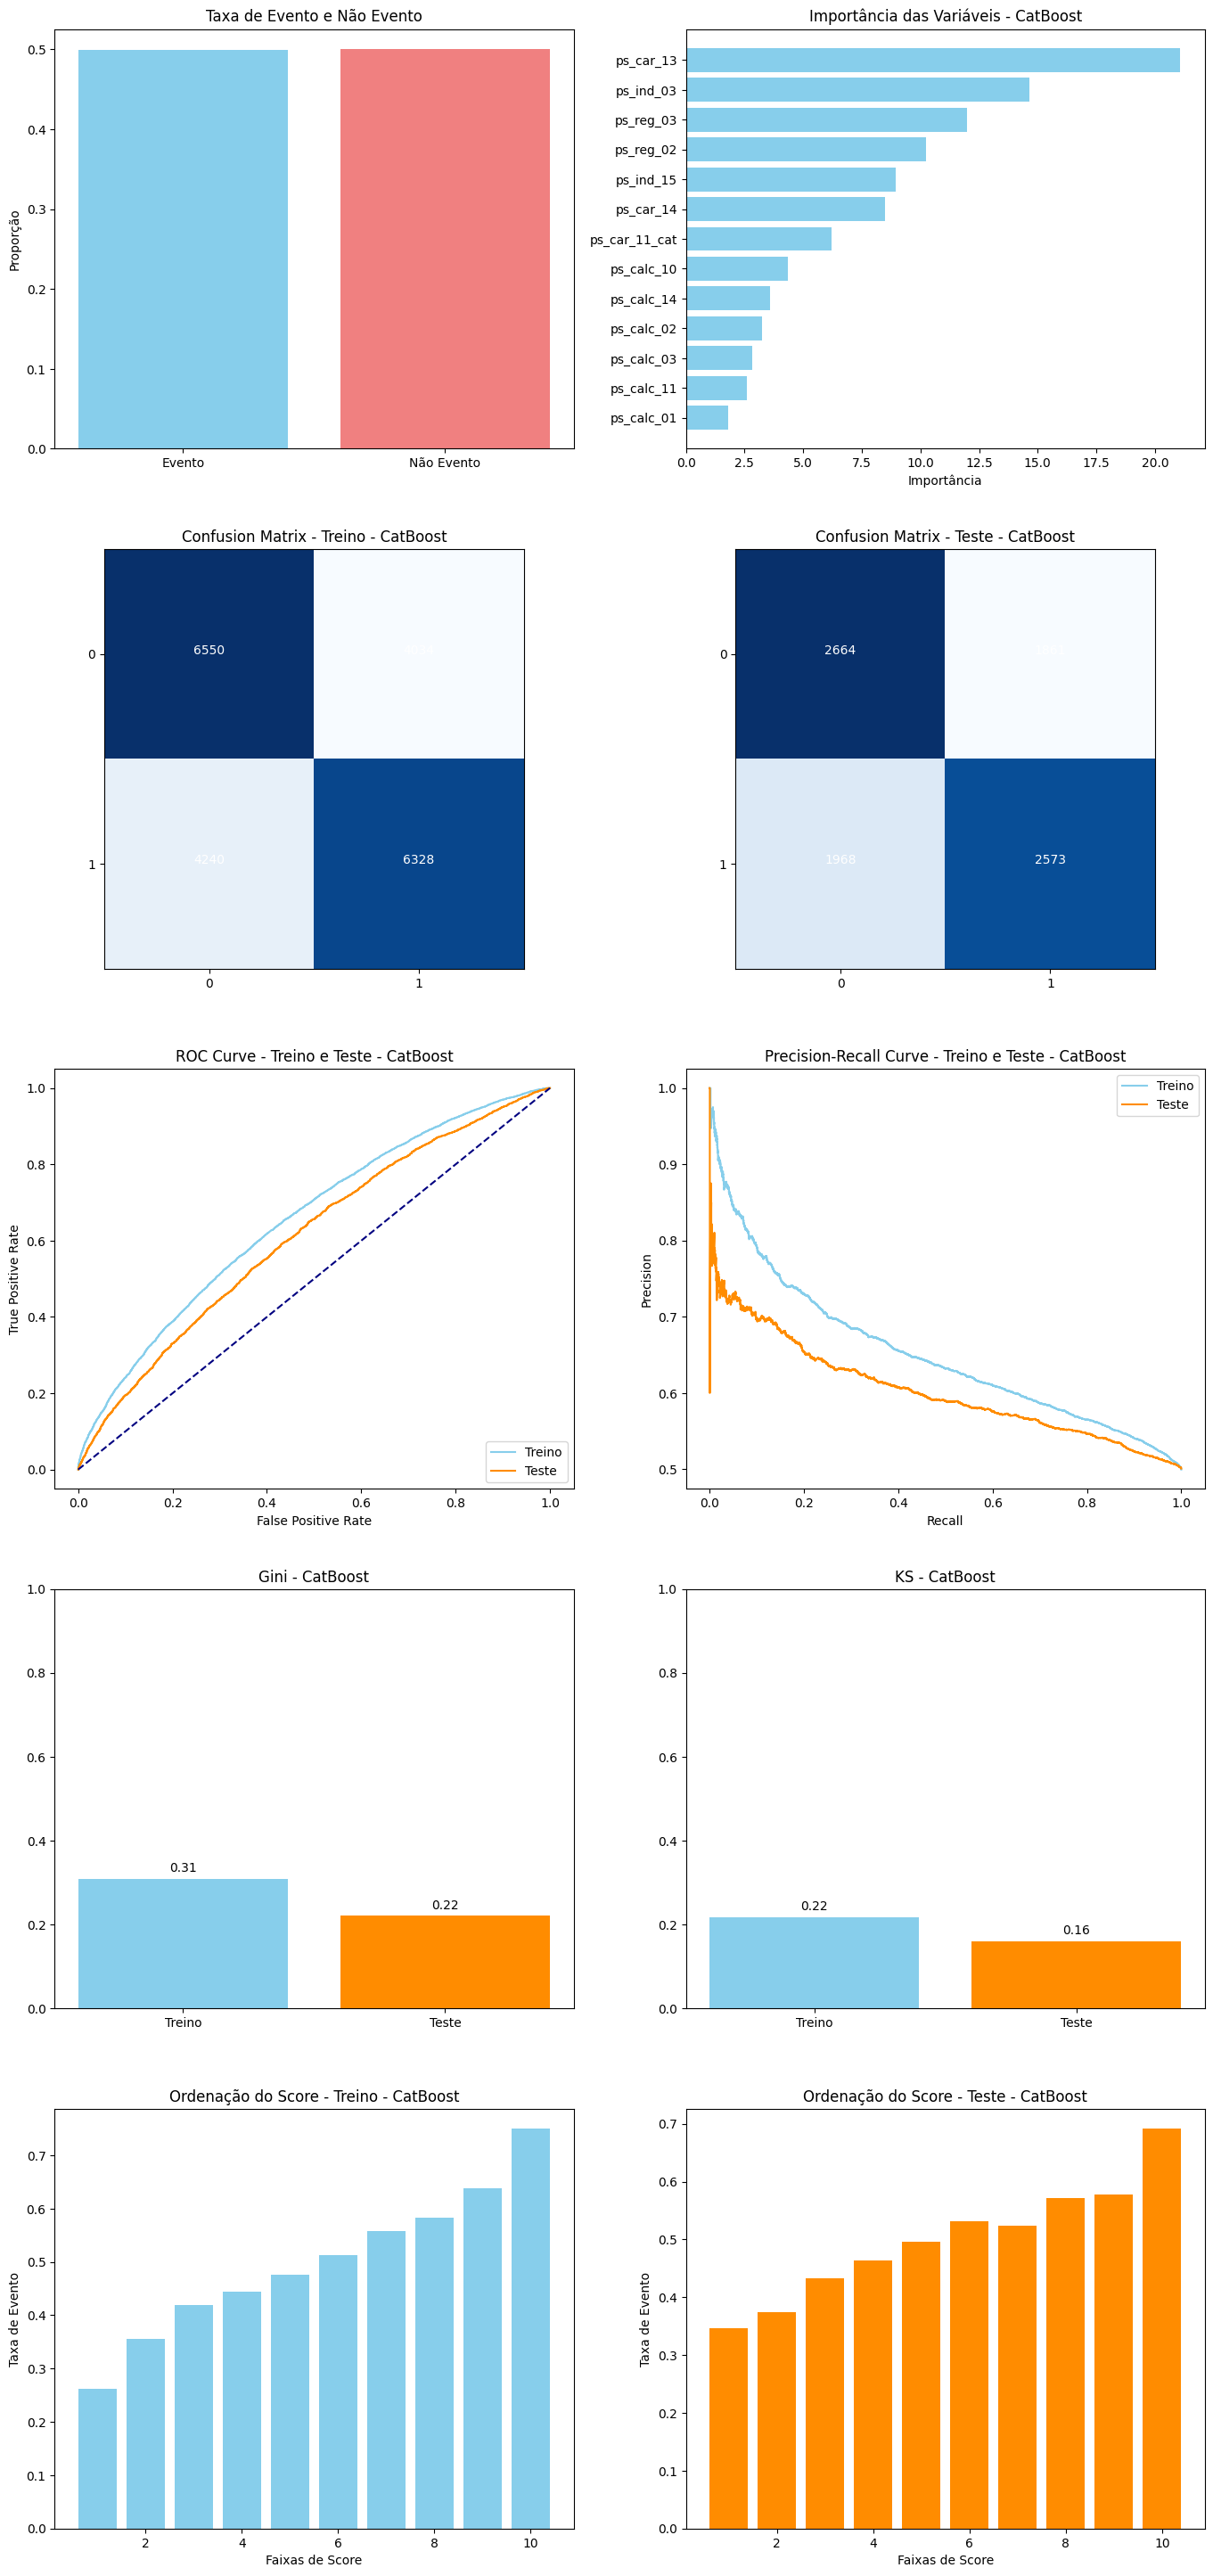

In [0]:
avaliar_modelo(X_train_cb, y_train, X_test_cb, y_test, best_model_cat, nm_modelo='CatBoost')

## Resultado

Considerando o critério oficial da competição — maximização do ROC AUC (e, consequentemente, do Gini) — o CatBoost se mostrou o modelo mais consistente para este problema.

Embora a diferença em relação ao XGBoost e ao LightGBM seja pequena, o CatBoost apresentou o melhor equilíbrio entre desempenho, estabilidade e capacidade de generalização. Este projeto reforça a importância de avaliar não apenas métricas finais, mas também o comportamento dos modelos entre treino e validação em problemas reais de risco.

In [0]:
import pandas as pd
import pickle

# Resultados já obtidos (substitua pelos valores reais)
resultados = {
    'Modelo': ['Logistic Regression','Random Forest', 'XGBoost', 'LightGBM', 'CatBoost'],
    'AUC': [grid_rl.best_score_, grid_FDC.best_score_, grid_XGB.best_score_, grid_LGB.best_score_,grid_cat.best_score_],
    'Gini Normalizado': [gini_rl, gini_RF, gini_XGB, gini_LGBM,gini_test  ]
}

# Criando DataFrame
df_resultados = pd.DataFrame(resultados)

# Encontrando o melhor modelo pelo AUC
melhor_gini = df_resultados.loc[df_resultados['Gini Normalizado'].idxmax()]


print("=== Comparação dos Modelos ===")
print(df_resultados)

print("\n✅ Modelo que se destacou pelo Gini:")
print(f"Modelo: {melhor_gini['Modelo']}")
print(f"AUC: {melhor_gini['AUC']}")
print(f"Gini Normalizado: {melhor_gini['Gini Normalizado']}")


=== Comparação dos Modelos ===
                Modelo       AUC  Gini Normalizado
0  Logistic Regression  0.599211          0.183000
1        Random Forest  0.605192          0.200000
2              XGBoost  0.610673          0.220000
3             LightGBM  0.609071          0.210000
4             CatBoost  0.614414          0.221632

✅ Modelo que se destacou pelo Gini:
Modelo: CatBoost
AUC: 0.6144141514672234
Gini Normalizado: 0.22163195732923224
